# Estimation of effective connectivity (EC) using MOU process for model
## Replication of results from the paper by [Senden et al. (2017)](#references)
This Python notebook aims to reproduce the results presented in the abovementioned paper. As the fundamental approach utilized in the paper matches exactly the one applied in a closely related project by Gilson et al. (ct. [MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), the code is heavily influenced by and partly taken from this source (explicit indications are not provided in this provisional version). The class MOU (multivariate Ornstein-Uhlenbeck) from the [*pyMOU* library](#references) (pymou.mou_model), which is used in that project, was adapted to match the procedure described in the paper to be reproduced (slightly different process model). The changes exclusively effect the method fit_LO().

The files listed below are required to be positioned in the same location the main file *replicate_results_from_Senden_et_al_paper.ipynb* is located. 
- *mou_model.py* (The adapted version of the eponymous file from the [*pyMOU* library](#references).)
- *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables.)
- *BINARY_EC_MASK.mat* (Anatomical connectome averaged over subjects (structural data).)

In [1]:
## Import dependencies.
import os
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{upgreek}')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator
from mou_model import MOU

#from IPython.display import Markdown, display 
#def printmd(string): 
#    display(Markdown(string))

## Check whether simple_colors is installed, otherwise install using pip
try:
    import simple_colors # for printing colored and bold text
except:
    ! pip install simple_colors

## Import simple_colors
from simple_colors import *

%matplotlib inline

## Introduce constants.
_RES_DIR = 'model_parameter/'
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0
seed = 0 # None

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)
    
## Flags
sample_groupsize= 'matched' # Valid options: 'matched', 'all subjects'
save_analyse_res_flag = False
analyse_mixed_groups_flag = False
scale_ts_flag = False
FC_max_shift_length_flag = True
sample_groups_flag = True # Is set to False as soon as a sample exists
tau_to_analyse = 1 # Ecpected values: whole numbers from 0 to maxtau
examine_patients_flag = True # If == False, control participants are examined
io_based_on_nodal_degree_flag = False
allow_all_connections_for_EC_flag = False
optimize_with_FC_version = 'FC_scaled_avg' #'FC_scaled_avg','FC_avg_scaled'or'FC_avg'
plot_FC_scaled_avg_flag = False # If == False, FC_avg_scaled is plottet
input_is_rowsum_flag = True # If == False, input = columnsum

In [2]:
## The following function was retrieved from 
# https://stackoverflow.com/questions/48970785/complex-matlab-struct-mat-file-read-by-python
# unchanged except from the prints, which were added to give the user a rough 
# idea of the data's structure.
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects.
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
#                print(key)
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
#                print(key)
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function constructing nested dictionaries from matobjects
        """
#        print('\tcontaining another dictionary with the keys')
        d = {}
        for strg in matobj._fieldnames:
#            print('\t', strg)
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
#        print('\t\tcontaining an array\n\t\t\tof shape', ndarray.shape, 
#              '\n\t\t\tand dtype', ndarray.dtype)
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray
        
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
 #   print('The data in', filename, 'consists of', len(data.keys()) - 3,
 #         'element(s) with the following keys:\n')
    return _check_vars(data)

### Data set
The data set consists of 5 sessions for 14 subjects: one each for rest, the n-back task, the flanker task, the mental rotation task, and the odd-man out task. Each session is about 6 minutes long and consists of 192 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to the Desikan-Killany (DK) atlas (Desikan et al., 2006; Klein & Tourville, 2012) with 68 regions of interest (ROIs).
The preprocessed fMRI data was downloaded from https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd. For more detailed information concerning the data follow the link above.

The data files are:
 - *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables)
 - *BINARY_EC_MASK.mat* (anatomical connectome averaged over subjects (structural data))

As the data format of the preprocessed data is different to the one in the aforementioned notebook by Gilson ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), it is restructured to match the format of the latter for enhanced comparability.

In [3]:
## Read in data and structure it.
# Read in ROI labels from Senden Paper to compare the order.
fMRI_data_and_labels = load_mat(
    'BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD')
keys_1st_layer = list(fMRI_data_and_labels.keys())
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels[keys_1st_layer[3]]
roi_labels = fMRI_data_and_labels[keys_1st_layer[4]]
# Read in SZ data.
fMRI_data = load_mat(
    'schizophrenics_data_and_data_description/cobre_schizo_aparc_ts')
keys_1st_layer = list(fMRI_data.keys())
data_per_subj = fMRI_data[keys_1st_layer[3]]
keys_2nd_layer = list(data_per_subj[0].keys())
#print('Subject with complete data, have the following keys:', str(keys_2nd_layer))
n_subjects = len(data_per_subj)
n_ts_samples, n_rois = data_per_subj[0]['timeseries'].shape 

## Chose only subjects for whom the full timeseries is present
timeseries = np.zeros([n_subjects, n_ts_samples, n_rois])
for i, i_subj in enumerate(data_per_subj):
    #print(i, '\t\t:', i_subj.keys())
    timeseries[i, :, :] = i_subj.get('timeseries')

## Exclude subjects who are marked for exclusion
subj_infos = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', header = 1)
mask_exclude_subj = subj_infos.loc[: , "Exlude?"]
mask_exclude_subj = mask_exclude_subj.replace("Motion",1)
mask_exclude_subj = mask_exclude_subj.replace("Disenrolled",1)
mask_exclude_subj = mask_exclude_subj.replace("Incomplete",1)
mask_exclude_subj = mask_exclude_subj.replace(np.nan,0)
mask_exclude_subj = mask_exclude_subj.to_numpy(dtype=bool)
true_timeseries = timeseries[~mask_exclude_subj]

## Separate healthy participants from schizophrenics
participant_type_labels = ["Control", "Patient"]
mask_patient_subj = subj_infos.loc[: , "Subject Type"]
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[0],0)
mask_patient_subj = mask_patient_subj.replace(participant_type_labels[1],1)
mask_patient_subj = mask_patient_subj.to_numpy(dtype=bool)
mask_patient_subj = mask_patient_subj[~mask_exclude_subj]
patients_timeseries = true_timeseries[mask_patient_subj]
patients_timeseries = patients_timeseries[
    np.logical_not(np.isnan(patients_timeseries))].reshape((-1,150,68))
control_timeseries = true_timeseries[~mask_patient_subj]
controls_timeseries = control_timeseries[
    np.logical_not(np.isnan(control_timeseries))].reshape((-1,150,68))
print('Participants with complete data:')
print('\t', patients_timeseries.shape[0], 'patient participants')
print('\t', controls_timeseries.shape[0], 'control participants')

ts_patients = np.transpose(patients_timeseries, (0, 2, 1))
ts_controls = np.transpose(controls_timeseries, (0, 2, 1))
n_subjects_patients, n_rois_patients, n_ts_samples_patients = \
ts_patients.shape
n_subjects_controls, n_rois_controls, n_ts_samples_controls = \
ts_controls.shape
    
## Confirm that the order and the names of regions is the same for the EC-mask
# and the BOLD-dat
labels_pd = pd.read_excel(
    'schizophrenics_data_and_data_description/cobre_schizoprenia.xlsx', 
    sheet_name='regions', usecols='C', header=1)
labels_pd = labels_pd.replace({'ctx-':''}, regex=True)
labels_pd = labels_pd.replace({' ':''}, regex=True)
labels_pd = labels_pd.replace({'-':'_'}, regex=True)
labels = np.concatenate(labels_pd.to_numpy())
print('The order and names of ROIs is the same for both, \
EC mask and BOLD data:', (labels == roi_labels).all())

Participants with complete data:
	 60 patient participants
	 69 control participants
The order and names of ROIs is the same for both, EC mask and BOLD data: True


In [4]:
def standard_scale_BOLD_ts(BOLD_ts):
    """Standardize BOLD timeseries so that mean=0 and std=1 for all subjects.
    
    This function scales the BOLD timeseries according to z = (x - u) / s, 
    where x is the timeseries, u it's mean and s the standard diviation. The
    scaler scales each subject so that it's timeseries fullfills the 
    abovementioned requirements.
    """
    n_subjects = BOLD_ts.shape[0]
    standard_scaler = StandardScaler()
    BOLD_ts_scaled = standard_scaler.fit_transform(
        BOLD_ts.reshape(n_subjects, -1).T).T.reshape(BOLD_ts.shape)
    return BOLD_ts_scaled

In [5]:
## Investigate distribution of BOLD timeseries values
def plot_ts_boxplot(BOLD_ts, group):
    plt.figure(figsize=(14, 14))
    plt.title(group)
    plt.ylabel('subject')
    plt.xlabel('ts value')
    n_subjects = BOLD_ts.shape[0]
    BOLD_ts = np.reshape(BOLD_ts, [n_subjects, -1])
    plt.boxplot(BOLD_ts.T, positions = np.arange(n_subjects), vert=False)
    plt.show()

#print(red('Investigate distribution of BOLD timeseries values:', 'bold'))
#plot_ts_boxplot(ts_patients, 'Patients')
#plot_ts_boxplot(ts_controls, 'Control group')

In [6]:
## Standardscale BOLD timeseries.
if scale_ts_flag:
#    print(red('Investigate distribution of scaled BOLD timeseries values:',
#              'bold'))
    ts_scaled_patients = standard_scale_BOLD_ts(ts_patients)
    ts_scaled_controls = standard_scale_BOLD_ts(ts_controls)
#    plot_ts_boxplot(ts_scaled_patients, 'Patients')
#    plot_ts_boxplot(ts_scaled_controls, 'Control group')

In [7]:
# lobe-mapping according to (insula counted to temporal (Wikipedia)):
# https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation
print_labels_flag = True
print_prints = False

# Define RC
rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
mask_rc = np.zeros(n_rois, dtype=bool)
for i_rc_label in rc_labels:
    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(labels).astype(
        bool)] = True
indexes_rich_club = np.array(*np.where(mask_rc))
if print_prints:
    print('Rich club regions:\n', roi_labels[mask_rc].tolist())
          #np.concatenate(roi_labels[mask_rc]).tolist())
labels_rc = roi_labels[mask_rc]
indexes_rc = np.array(*np.where(mask_rc))

frontal_labels = ['frontal', 'pars', 'precentral', 'paracentral']
mask_frontal = np.zeros(n_rois, dtype=bool)
for i_label in frontal_labels:
    mask_frontal[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_frontal = np.array(*np.where(mask_frontal))

parietal_labels = ['parietal', 'supramarginal', 'postcentral', 'precuneus']
mask_parietal = np.zeros(n_rois, dtype=bool)
for i_label in parietal_labels:
    mask_parietal[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_parietal = np.array(*np.where(mask_parietal))

temporal_labels = ['temporal', 'banks', 'fusiform', 'entorhinal',
                   'parahippocampal']
mask_temporal = np.zeros(n_rois, dtype=bool)
for i_label in temporal_labels:
    mask_temporal[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_temporal = np.array(*np.where(mask_temporal))

occipital_labels = ['occipital', 'lingual', '_cuneus', 'pericalcarine']
mask_occipital = np.zeros(n_rois, dtype=bool)
for i_label in occipital_labels:
    mask_occipital[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_occipital = np.array(*np.where(mask_occipital))

cingulate_labels = ['cingulate']
mask_cingulate = np.zeros(n_rois, dtype=bool)
for i_label in cingulate_labels:
    mask_cingulate[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_cingulate = np.array(*np.where(mask_cingulate))


# Here follows the categorization with every roi followed by same roi of other hemisphere.
indexes_lh = np.zeros(0, dtype=int)
for i_label in frontal_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_frontal = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_frontal[0::2] = indexes_lh
indexes_frontal[1::2] = indexes_lh + n_rois/2    
    
indexes_lh = np.zeros(0, dtype=int)
for i_label in parietal_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_parietal = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_parietal[0::2] = indexes_lh
indexes_parietal[1::2] = indexes_lh + n_rois/2

indexes_lh = np.zeros(0, dtype=int)
for i_label in temporal_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_temporal = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_temporal[0::2] = indexes_lh
indexes_temporal[1::2] = indexes_lh + n_rois/2

indexes_lh = np.zeros(0, dtype=int)
for i_label in cingulate_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_cingulate = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_cingulate[0::2] = indexes_lh
indexes_cingulate[1::2] = indexes_lh + n_rois/2

indexes_lh = np.zeros(0, dtype=int)
for i_label in occipital_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_occipital = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_occipital[0::2] = indexes_lh
indexes_occipital[1::2] = indexes_lh + n_rois/2

indexes_insula = np.array(
    *np.where(np.frompyfunc(lambda x: 'insula' in x, 1, 1)(roi_labels)))

if print_labels_flag:
    print('frontal:', roi_labels[indexes_frontal])
    print('parietal:', roi_labels[indexes_parietal])
    print('temporal:', roi_labels[indexes_temporal])
    print('occipital:', roi_labels[indexes_occipital])
    print('cingulate:', roi_labels[indexes_cingulate])

roi_indexes_categorized = [*indexes_frontal, *indexes_parietal,
                           *indexes_temporal, *indexes_occipital,
                           *indexes_cingulate, *indexes_insula]
roi_labels_categorized = roi_labels[roi_indexes_categorized]
indexes_rc_categorized = list(list(roi_labels_categorized).index(i_label)
                              for i_label in labels_rc)

temp = np.zeros(len(indexes_rc), dtype=int)
temp[0::2] = indexes_rc[0:3]
temp[1::2] = indexes_rc[3:6]
indexes_rc = temp

frontal: ['lh_caudalmiddlefrontal' 'rh_caudalmiddlefrontal'
 'lh_lateralorbitofrontal' 'rh_lateralorbitofrontal'
 'lh_medialorbitofrontal' 'rh_medialorbitofrontal'
 'lh_rostralmiddlefrontal' 'rh_rostralmiddlefrontal' 'lh_superiorfrontal'
 'rh_superiorfrontal' 'lh_frontalpole' 'rh_frontalpole'
 'lh_parsopercularis' 'rh_parsopercularis' 'lh_parsorbitalis'
 'rh_parsorbitalis' 'lh_parstriangularis' 'rh_parstriangularis'
 'lh_precentral' 'rh_precentral' 'lh_paracentral' 'rh_paracentral']
parietal: ['lh_inferiorparietal' 'rh_inferiorparietal' 'lh_superiorparietal'
 'rh_superiorparietal' 'lh_supramarginal' 'rh_supramarginal'
 'lh_postcentral' 'rh_postcentral' 'lh_precuneus' 'rh_precuneus']
temporal: ['lh_inferiortemporal' 'rh_inferiortemporal' 'lh_middletemporal'
 'rh_middletemporal' 'lh_superiortemporal' 'rh_superiortemporal'
 'lh_temporalpole' 'rh_temporalpole' 'lh_transversetemporal'
 'rh_transversetemporal' 'lh_bankssts' 'rh_bankssts' 'lh_fusiform'
 'rh_fusiform' 'lh_entorhinal' 'rh_entor

In [8]:
## Just some testing
#with np.printoptions(threshold=np.inf):
#    print(true_timeseries[1:16])
#n_runs=1
#np.squeeze(np.zeros([n_subjects, n_runs, n_rois, n_rois])).shape

### Functional connectivity (FC)
As the BOLD covariances "are natural objective functions for the MOU model," ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) they are used as  functional connectivity here. The BOLD time series are zero-centered in order to eliminate offset differences between runs.

In [9]:
### Length of BOLD data dependent on tau like in tau_lag_correlation.m.
## Calculate functional connectivity (BOLD covariances).
def calculate_FC_shift(ts_emp, n_shifts, **kwargs):
    n_subjects, n_rois, n_ts_samples = ts_emp.shape
    FC_shift = np.zeros([n_subjects, n_rois, n_rois])
    FC_Reuters = np.zeros([n_subjects, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts
    for i_subject in range(n_subjects):
        # Center the time series (around zero).
        ts_emp[i_subject, :, :] -=  \
                np.outer(ts_emp[i_subject, :, :].
                         mean(axis=1), np.ones([n_ts_samples]))
        # Calculate covariances with one time shift.
        for i_roi in range(n_rois):
            FC_shift[i_subject, :, i_roi] = \
            np.dot(ts_emp[i_subject, :,
                                   :n_ts_span], 
                   ts_emp[i_subject, i_roi,
                                   n_shifts:]) / float(n_ts_span)               
    return FC_shift

In [10]:
### Length of BOLD data dependent on maximal tau.
def calculate_FC_same_timeseries_length(ts, max_shift):
    """ This function calculates the FC represented by the BOLD covariances.
    The length of the timeseries is the same for all covariances and only 
    depends on the maximum shift 'max_shift'.
    """
    n_subjects, n_rois, n_ts_samples = ts.shape
    time_shifts = np.arange(max_shift + 1, dtype=int)
    n_shifts = len(time_shifts)
    centered_ts = np.copy(ts)
    FC = np.zeros([n_subjects, n_shifts, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts
    for i_subject in range(n_subjects):
        # Center the time series (around zero).
        centered_ts[i_subject, :, :] -=  \
                np.outer(centered_ts[i_subject, :, :].
                         mean(axis=1), np.ones([n_ts_samples]))
        # Calculate covariances with various time shifts.
        for i_shift in range(n_shifts):
            for i_roi in range(n_rois):
                FC[i_subject, i_shift, :, i_roi] = \
                (np.dot(centered_ts[i_subject, :,
                                       0:n_ts_span],
                       centered_ts[i_subject, i_roi,
                                       i_shift:n_ts_span + i_shift]) 
                 / float(n_ts_span))              
    return centered_ts, FC

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.1346500136785475
Mean FC0 value: 0.021578078029704625
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.37577938046643894


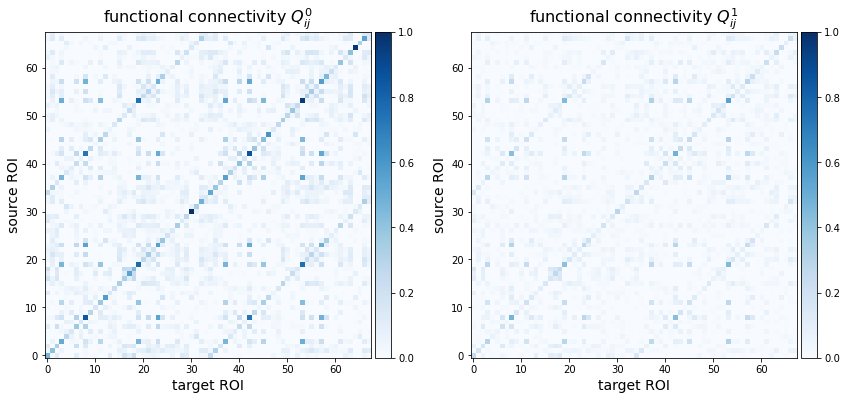

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.07172274135910638
Mean FC0 value: 0.019284866285143497
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.22224420525366476


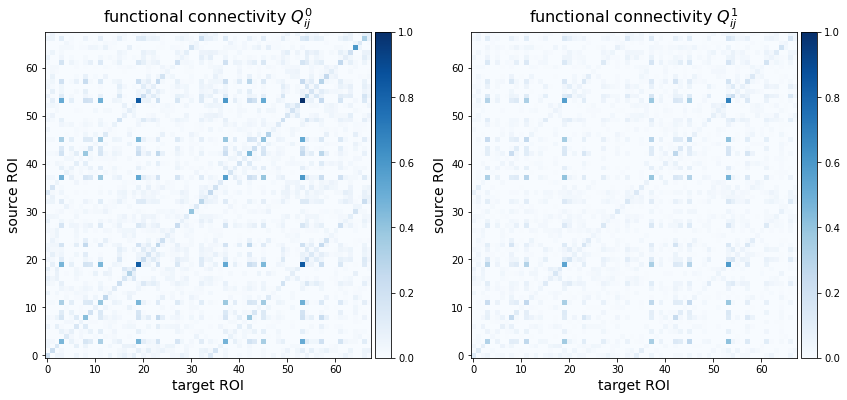

In [11]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shifts = np.arange(4, dtype=int)
n_shifts = len(time_shifts)
if scale_ts_flag:
    ts_p = ts_scaled_patients
    ts_c = ts_scaled_controls
else:
    ts_p = ts_patients
    ts_c = ts_controls
if FC_max_shift_length_flag:
    max_shift = 1
    centered_ts_patients, FC_patients = \
    calculate_FC_same_timeseries_length(ts_p, max_shift)
    centered_ts_controls, FC_controls = \
    calculate_FC_same_timeseries_length(ts_c, max_shift)
else:
    FC_patients = np.ndarray([n_subjects_patients, n_shifts, 
                              n_rois_patients, n_rois_patients])
    for time_shift in time_shifts:
        FC_patients[:, time_shift, :, :] = calculate_FC_shift(
            ts_p, time_shift)
    FC_controls = np.ndarray([n_subjects_controls, n_shifts, 
                          n_rois_controls, n_rois_controls])
    for time_shift in time_shifts:
        FC_controls[:, time_shift, :, :] = calculate_FC_shift(
            ts_c, time_shift)

## Examine patients
# Scale FC so that the max value of every subject's FC is 1.
FC_patients_scaled = FC_patients/FC_patients[:, _I_NO_TIMESHIFT,:, :].max(
    axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
# Visualize the effect of the scaling by printing the relevant values.
#print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

# Average FC over subjects.
FC_patients_avg = FC_patients.mean(axis=_SUBJECT_AXIS)
FC_patients_scaled_avg = FC_patients_scaled.mean(axis=_SUBJECT_AXIS)
# Scale FC_avg so that the maximal value for each run is 1.
FC_patients_avg_scaled = FC_patients_avg/FC_patients_avg[
    _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
    np.newaxis, np.newaxis, np.newaxis]
# Visualize the effect of the scaling by printing the relevant values.
#print('\nMaxima of FC_avg_scaled:\n\n', FC_avg_scaled.max(axis=2).max(axis=2))

if plot_FC_scaled_avg_flag:
    plotted_FC_version = FC_patients_scaled_avg
else:
    plotted_FC_version = FC_patients_avg_scaled
print('Due to the application of the min-max-scaler most of the FC values \
should be between 0 and 1')
print('Min FC0 value:', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
print('Mean FC0 value:', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
print('Max FC0 value:', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
# print('Min FC0 value:', FC0_rest_subj_avg_scaled.min())
# print('Max FC0 value:', FC0_rest_subj_avg_scaled.max())
print('Mean BOLD variance (diagonal of each FC0 matrix):', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
          axis1=0, axis2=1).mean())
#     # Show distibution of FC0 values.
#     plt.figure()
#     plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
#              bins=np.linspace(-1, 5, 30))
#     plt.xlabel('FC0 value', fontsize=14)
#     plt.ylabel('matrix element count', fontsize=14)
#     plt.title('distribution of FC0 values')

# Show FC0 averaged over subjects.
plt.figure(figsize=(14, 6))
plt.subplot(121)
FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

# Show FC1 averaged over subjects for.
plt.subplot(122)
FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
plt.show()

## Examine control FC.
# Scale FC so that the max value of every subject's FC is 1.
FC_controls_scaled = FC_controls/FC_controls[:, _I_NO_TIMESHIFT,:, :].max(
    axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
# Visualize the effect of the scaling by printing the relevant values.
#print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

# Average FC over subjects.
FC_controls_avg = FC_controls.mean(axis=_SUBJECT_AXIS)
FC_controls_scaled_avg = FC_controls_scaled.mean(axis=_SUBJECT_AXIS)
# Scale FC_avg so that the maximal value for each run is 1.
FC_controls_avg_scaled = FC_controls_avg/FC_controls_avg[
    _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
    np.newaxis, np.newaxis, np.newaxis]
# Visualize the effect of the scaling by printing the relevant values.
#print('\nMaxima of FC_avg_scaled:\n\n', FC_avg_scaled.max(axis=2).max(axis=2))

if plot_FC_scaled_avg_flag:
    plotted_FC_version = FC_controls_scaled_avg
else:
    plotted_FC_version = FC_controls_avg_scaled
print('Due to the application of the min-max-scaler most of the FC values \
should be between 0 and 1')
print('Min FC0 value:', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].min())
print('Mean FC0 value:', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].mean())
print('Max FC0 value:', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].max())
# print('Min FC0 value:', FC0_rest_subj_avg_scaled.min())
# print('Max FC0 value:', FC0_rest_subj_avg_scaled.max())
print('Mean BOLD variance (diagonal of each FC0 matrix):', 
      plotted_FC_version[_I_NO_TIMESHIFT, :, :].diagonal(
          axis1=0, axis2=1).mean())
#     # Show distibution of FC0 values.
#     plt.figure()
#     plt.hist(plotted_FC_version[_I_NO_TIMESHIFT, :, :].flatten(),
#              bins=np.linspace(-1, 5, 30))
#     plt.xlabel('FC0 value', fontsize=14)
#     plt.ylabel('matrix element count', fontsize=14)
#     plt.title('distribution of FC0 values')

# Show FC0 averaged over subjects.
plt.figure(figsize=(14, 6))
plt.subplot(121)
FC0 = plotted_FC_version[_I_NO_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC0, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)

# Show FC1 averaged over subjects for.
plt.subplot(122)
FC1 = plotted_FC_version[_I_ONE_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC1, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
plt.show()

The following calculations are based on FC_scaled_avg and scaled BOLD ts: False


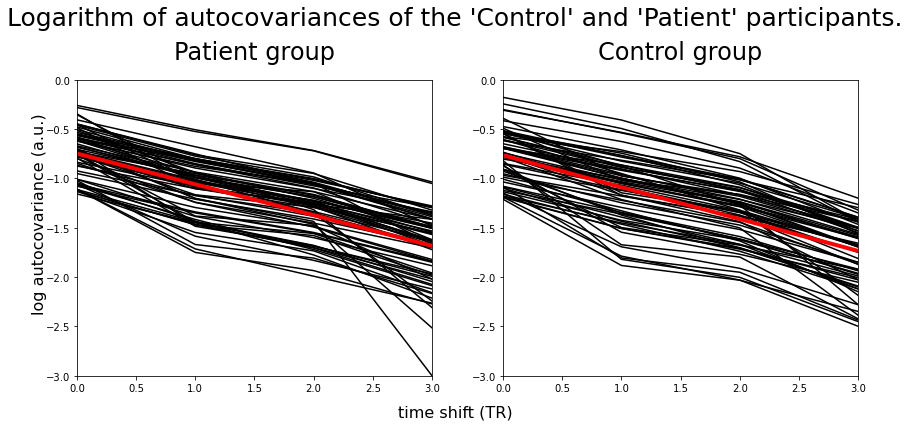

2.906465196731615
2.6982163184988157


In [12]:
## Calculate the logarithm of the autocovariance.
#ylim = -2.5 # for calculation with log10 instead of log
ylim_min = -3
ylim_max = 0
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
top_adjust = 0.81

if scale_ts_flag:
    ts_p = ts_scaled_patients
    ts_c = ts_scaled_controls
else:
    ts_p = ts_patients
    ts_c = ts_controls
if FC_max_shift_length_flag:
    max_shift = max(time_shifts)
    centered_ts_patients, FC_patients = \
    calculate_FC_same_timeseries_length(ts_p, max_shift)
    centered_ts_controls, FC_controls = \
    calculate_FC_same_timeseries_length(ts_c, max_shift)

    # Scale FC so that the max value of every subject's FC is 1.
    FC_patients_scaled = FC_patients/FC_patients[:, _I_NO_TIMESHIFT,:, :].max(
        axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
    FC_controls_scaled = FC_controls/FC_controls[:, _I_NO_TIMESHIFT,:, :].max(
        axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]

    # Average FC over subjects.
    FC_patients_avg = FC_patients.mean(axis=_SUBJECT_AXIS)
    FC_patients_scaled_avg = FC_patients_scaled.mean(axis=_SUBJECT_AXIS)
    FC_controls_avg = FC_controls.mean(axis=_SUBJECT_AXIS)
    FC_controls_scaled_avg = FC_controls_scaled.mean(axis=_SUBJECT_AXIS)
    # Scale FC_avg so that the maximal value for each run is 1.
    FC_patients_avg_scaled = FC_patients_avg/FC_patients_avg[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]
    FC_controls_avg_scaled = FC_controls_avg/FC_controls_avg[
        _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
        np.newaxis, np.newaxis, np.newaxis]

if optimize_with_FC_version == 'FC_scaled_avg':
    FC_patients = FC_patients_scaled_avg
    FC_controls = FC_controls_scaled_avg
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC_patients = FC_patients_avg_scaled
    FC_controls = FC_controls_avg_scaled
elif optimize_with_FC_version == 'FC_avg':
    FC_patients = FC_patients_avg
    FC_controls = FC_controls_avg
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_scaled_avg', 'FC_avg_scaled',\
    'FC_avg' (default).")
    FC_patients = FC_patients_avg
    FC_controls = FC_controls_avg

ac_patients = FC_patients[:, :, :].diagonal(axis1=1, axis2=2)
log_ac_patients = np.log10(np.maximum(ac_patients[:, :], pow(10, ylim_min)))
#log_ac_patients = np.log(np.maximum(ac_patients[:, :], pow(np.exp(1), ylim_min)))
v_tau_patient = np.arange(ac_patients.shape[0], dtype=np.float)

ac_controls = FC_controls[:, :, :].diagonal(axis1=1, axis2=2)
log_ac_controls = np.log10(np.maximum(ac_controls[:, :], pow(10, ylim_min)))
#log_ac_controls = np.log(np.maximum(ac_controls[:, :], pow(np.exp(1), ylim_min)))
v_tau_controls = np.arange(ac_controls.shape[0], dtype=np.float)

# Show the logarithm of the autocovariances for patients.
print('The following calculations are based on', optimize_with_FC_version,
      'and scaled BOLD ts:', scale_ts_flag)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle(str("Logarithm of autocovariances of the '" 
                 + participant_type_labels[0] + "' and '"
                 + participant_type_labels[1]
                 + "' participants."), fontsize=suptitle_fontsize)
fig.subplots_adjust(top=top_adjust)
fig.text(0.5, 0.03, 'time shift (TR)',
         ha='center', fontsize=axis_lable_fontsize)
fig.text(0.08, 0.5, 'log autocovariance (a.u.)', va='center',
         rotation='vertical', fontsize=axis_lable_fontsize)
plt.subplot(121)
plt.plot(range(n_shifts), log_ac_patients[:,:], '-k')
lin_reg_patients = np.polyfit( np.repeat(v_tau_patient, n_rois), 
                          log_ac_patients[:,:].reshape(-1), 1 )
plt.plot(v_tau_patient, lin_reg_patients[0]*v_tau_patient
         + lin_reg_patients[1], '-r', linewidth=4)
plt.title('Patient group', fontsize=title_fontsize, y=1.05)
plt.ylim((ylim_min, ylim_max))
plt.xlim((0, n_shifts-1))

# Show the logarithm of the autocovariances for control subjects.
plt.subplot(122)
plt.plot(range(n_shifts), log_ac_controls[:,:], '-k')
lin_reg_controls = np.polyfit(np.repeat(v_tau_controls, n_rois), 
                           log_ac_controls[:,:].reshape(-1), 1 )
plt.plot(v_tau_controls, lin_reg_controls[0]*v_tau_controls
         + lin_reg_controls[1], '-r', linewidth=4)
plt.title('Control group', fontsize=title_fontsize, y=1.05)
plt.ylim((ylim_min, ylim_max))
plt.xlim((0, n_shifts-1))
plt.show()

tau_x_controls = 1/(log_ac_controls[_I_NO_TIMESHIFT, :]-log_ac_controls[_I_ONE_TIMESHIFT, :]).mean()
tau_x_patients = 1/(log_ac_patients[_I_NO_TIMESHIFT, :]-log_ac_patients[_I_ONE_TIMESHIFT, :]).mean()
print(tau_x_controls)
print(tau_x_patients)

### Structural connectivity (SC)
The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper, it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates 'the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned [Senden et al. (2017)](#references) paper.

In [13]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hemispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True

# Visualise the binary structural connectivity mask.
#mask_EC = mask_EC[roi_indexes_categorized, :]
#mask_EC = mask_EC[:, roi_indexes_categorized]
#
#frontal_start = 0
#frontal_end = len(indexes_frontal) - 1
#parietal_start = frontal_end + 1
#parietal_end = parietal_start + len(indexes_parietal) - 1
#temporal_start = parietal_end + 1
#temporal_end = temporal_start + len(indexes_temporal) - 1
#occipital_start = temporal_end + 1
#occipital_end = occipital_start + len(indexes_occipital) - 1
#cingulate_start = occipital_end + 1
#cingulate_end = cingulate_start + len(indexes_cingulate) - 1
#
#plt.figure(figsize=(14, 14))
#plt.imshow(mask_EC, origin='lower')
#plt.xlabel('target ROI', fontsize=14)
#plt.ylabel('source ROI', fontsize=14)
#plt.title('Mask for existing connections', fontsize=12)
##plt.show()
#
## Emphsize rc labels
#axtypes = ['xaxis', 'yaxis']
#rc_indexes = list(list(
#    roi_labels_categorized).index(i_label) for i_label in labels_rc)
#
#ax=plt.gca()
#ax.xaxis.tick_top()
#ax.xaxis.set_ticks_position('top')
#ax.set_xlabel('target ROI', fontsize=14)
#ax.set_xticks(np.arange(68))
#ax.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
#ax.set_ylabel('source ROI', fontsize=14)
#ax.set_yticks(np.arange(68))
#ax.set_yticklabels(roi_labels_categorized, fontsize = 10)
#for ax_type in axtypes:
#    [label.set_fontsize(15) for label in 
#     map(getattr(ax, ax_type).get_majorticklabels().__getitem__, rc_indexes)]
#
#    [label.set_color('green') for label in 
#     map(getattr(ax, ax_type).get_majorticklabels().__getitem__,
#         np.linspace(frontal_start, frontal_end, len(indexes_frontal), dtype=int))]
#
#    [label.set_color('green') for label in 
#     map(getattr(ax, ax_type).get_majorticklabels().__getitem__,
#         np.linspace(temporal_start, temporal_end, len(indexes_temporal), dtype=int))]
#
#    [label.set_color('green') for label in 
#     map(getattr(ax, ax_type).get_majorticklabels().__getitem__,
#         np.linspace(cingulate_start, cingulate_end, len(indexes_cingulate), dtype=int))]
plt.show()

if allow_all_connections_for_EC_flag:
    mask_EC = None

### MOU-EC estimation
'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the [*MOU_Simulation_Estimation* notebook](#references).

The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) In the paper (ct. [Senden et al. (2017)](#references)) $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ were chosen. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit@MOU method, have the correct defaults in fit_LO@MOU.

Depending on the value of $\epsilon_C$ the following cell might take about 30 minutes ($\epsilon_C = 0.0001) and more to run through.

# <p style="text-align: center;"> <span style="color:red">*Before optimization!*</span></p>

In [14]:
## Calculate EC-matrix for patients.
# Construct diagonal mask for input noise matrix
# (here, no input cross-correlation).
mask_Sigma = np.eye(n_rois_patients, dtype=bool)

# Run the model optimization.
# Initialize the source arrays.
# Jacobian (off-diagonal elements = EC)
J_mod_patients = np.zeros([n_rois_patients, n_rois_patients])
J_mod_controls = np.zeros([n_rois_patients, n_rois_patients])
# Local variance (input covariance matrix, chosen to be diagonal)
Sigma_mod_patients = np.zeros([n_rois_patients, n_rois_patients])
Sigma_mod_controls = np.zeros([n_rois_patients, n_rois_patients])
# Model error
dist_mod_patients = np.zeros([1])
dist_mod_controls = np.zeros([1])
# Approximation of variance about the fitted data (FC covariance matrices)
R2_mod_patients = np.zeros([1])
R2_mod_controls = np.zeros([1])
# Between-region EC matrix
C_patients = np.zeros([n_rois_patients, n_rois_patients])
C_controls = np.zeros([n_rois_patients, n_rois_patients])

C = np.zeros([n_rois_patients, n_rois_patients])
i_tau_opt = 1

## Run the estimation of model parameters for patients.
if optimize_with_FC_version == 'FC_scaled_avg':
    FC = FC_patients_scaled_avg
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC = FC_patients_avg_scaled
elif optimize_with_FC_version == 'FC_avg':
    FC = FC_patients_avg
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_scaled_avg', 'FC_avg_scaled',\
    'FC_avg' (default).")
    FC = FC_patients_avg

mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
mou_model.fit_LO(FC, i_tau_opt, mask_Sigma=mask_Sigma, 
                 mask_C=mask_EC)
# Organize the optimization results into arrays.
# Extract Jacobian of the model.
J_mod_patients[:, :] = mou_model.J
# Extract noise (auto-)covariance matrix.
Sigma_mod_patients[:, :] = mou_model.Sigma
# Extract the matrix distance between the empirical objective
# covariances and their model counterparts
# (normalized for each objective matrix).
dist_mod_patients = mou_model.d_fit['distance']
# The squared Pearson correlation is taken as an approximation
# of the variance.
R2_mod_patients = mou_model.d_fit['correlation']**2
# The between-region EC matrix of the model
C_patients[:, :] = mou_model.get_C()

print('group:', participant_type_labels[1], ';\t model error, R2:',
      dist_mod_patients, R2_mod_patients)

# Store the results in files.
np.save(_RES_DIR + 'FC_patients.npy',
        FC_patients)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'mask_EC.npy',
        mask_EC)  # Mask of optimized connections
np.save(_RES_DIR + 'mask_Sigma.npy',
        mask_Sigma)  # Mask of optimized Sigma elements
np.save(_RES_DIR + 'Sigma_mod_patients.npy',
        Sigma_mod_patients)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod_patients.npy',
        dist_mod_patients)  # Model error
np.save(_RES_DIR + 'J_mod_patients.npy',
        J_mod_patients)  # Estimated Jacobian, EC + inverse time const. on diag.

## Run the estimation of model parameters for controls.
if optimize_with_FC_version == 'FC_scaled_avg':
    FC = FC_controls_scaled_avg
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC = FC_controls_avg_scaled
elif optimize_with_FC_version == 'FC_avg':
    FC = FC_controls_avg
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_patients_scaled_avg', 'FC_patients_avg_scaled',\
    'FC_patients_avg' (default).")
    FC = FC_controls_avg

mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().
mou_model.fit_LO(FC, i_tau_opt, mask_Sigma=mask_Sigma, 
                 mask_C=mask_EC)
# Organize the optimization results into arrays.
# Extract Jacobian of the model.
J_mod_controls[:, :] = mou_model.J
# Extract noise (auto-)covariance matrix.
Sigma_mod_controls[:, :] = mou_model.Sigma
# Extract the matrix distance between the empirical objective
# covariances and their model counterparts
# (normalized for each objective matrix).
dist_mod_controls = mou_model.d_fit['distance']
# The squared Pearson correlation is taken as an approximation
# of the variance.
R2_mod_controls = mou_model.d_fit['correlation']**2
# The between-region EC matrix of the model
C_controls[:, :] = mou_model.get_C()

print('group:', participant_type_labels[0], ';\t model error, R2:',
      dist_mod_controls, R2_mod_controls)

# Store the results in files.
np.save(_RES_DIR + 'FC_controls.npy',
        FC_controls)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'Sigma_mod_controls.npy',
        Sigma_mod_controls)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod_controls.npy',
        dist_mod_controls)  # Model error
np.save(_RES_DIR + 'J_mod_controls.npy',
        J_mod_controls)  # Estimated Jacobian, EC + inverse time const. on diag.
print('\nFinished.')

tau_x: 1.1718204581053429
group: Patient ;	 model error, R2: 0.4692151010736452 0.565043451396384
tau_x: 1.2622617967843897
group: Control ;	 model error, R2: 0.35558613335904765 0.6653488608694037

Finished.


# <p style="text-align: center;"> <span style="color:red">*After optimization!*</span></p>

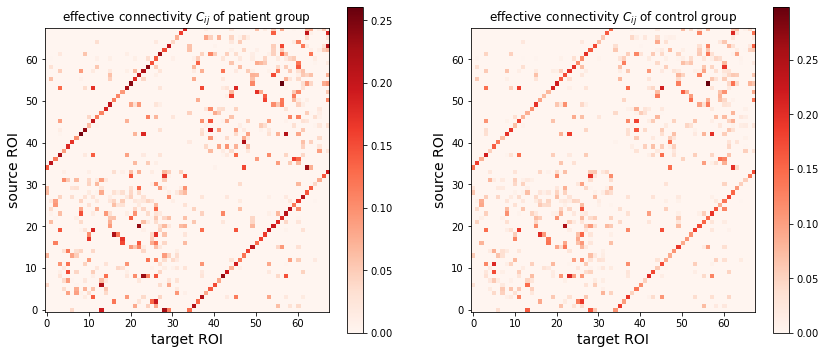

In [15]:
# Plot C-matrix for resting state data.
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(C_patients[:, :], origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$ of patient group')
plt.subplot(122)
plt.imshow(C_controls[:, :], origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$ of control group')
plt.show()
#savemat(_RES_DIR + 'C_patients.mat', {'C_patients': C_patients})
#savemat(_RES_DIR + 'C_controls.mat', {'C_controls': C_controls})

In [16]:
## Analyze EC-matrixes.
#io_based_on_nodal_degree_flag = True
# Find indexes of EC maxima.
print(black('Indexes of EC maxima:', 'bold'))
for i in range(5):
    print('\t', str(i+1) + '. largest value')
    print('\t\tpatient:\n\t\t', np.where(C_patients == np.sort(C_patients, axis=None)[-i-1]))
    print('\t\tcontrol:\n\t\t', np.where(C_controls == np.sort(C_controls, axis=None)[-i-1]))

## Analyze FC-matrixes
# Find indexes of FC maxima
print(black('Indexes of FC maxima:', 'bold'))
tau = tau_to_analyse    
#optimize_with_FC_version = 'FC_avg_scaled'
if optimize_with_FC_version == 'FC_scaled_avg':
    FC_patients = FC_patients_scaled_avg[tau, :, :]
    FC_controls = FC_controls_scaled_avg[tau, :, :]
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC_patients = FC_patients_avg_scaled[tau, :, :]
    FC_controls = FC_controls_avg_scaled[tau, :, :]
elif optimize_with_FC_version == 'FC_avg':
    FC_patients = FC_patients_avg[tau, :, :]
    FC_controls = FC_controls_avg[tau, :, :]
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_patients_scaled_avg', 'FC_patients_avg_scaled',\
    'FC_patients_avg' (default).")
    FC_patients = FC_patients_avg[tau, :, :]
    FC_controls = FC_controls_avg[tau, :, :]
for i in range(5):
    print('\t', str(i+1) + '. largest value')
    print('\t\tpatient:\n\t\t', np.where(FC_patients == np.sort(FC_patients, axis=None)[-i-1]))
    print('\t\tcontrol:\n\t\t', np.where(FC_controls == np.sort(FC_controls, axis=None)[-i-1]))

Indexes of EC maxima:
	 1. largest value
		patient:
		 (array([54], dtype=int64), array([56], dtype=int64))
		control:
		 (array([54], dtype=int64), array([56], dtype=int64))
	 2. largest value
		patient:
		 (array([42], dtype=int64), array([8], dtype=int64))
		control:
		 (array([20], dtype=int64), array([22], dtype=int64))
	 3. largest value
		patient:
		 (array([54], dtype=int64), array([20], dtype=int64))
		control:
		 (array([54], dtype=int64), array([20], dtype=int64))
	 4. largest value
		patient:
		 (array([58], dtype=int64), array([24], dtype=int64))
		control:
		 (array([53], dtype=int64), array([45], dtype=int64))
	 5. largest value
		patient:
		 (array([43], dtype=int64), array([9], dtype=int64))
		control:
		 (array([37], dtype=int64), array([3], dtype=int64))
Indexes of FC maxima:
	 1. largest value
		patient:
		 (array([42], dtype=int64), array([42], dtype=int64))
		control:
		 (array([53], dtype=int64), array([53], dtype=int64))
	 2. largest value
		patient:
		 (array([

### Local variability
As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions.

In [17]:
## Calculate local variability for rich club and periphery.
# Create a 1D-mask for rich club regions.
mask_rc = np.zeros(n_rois, dtype=bool)
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n',
      roi_labels[indexes_rich_club].tolist())
      #np.concatenate(roi_labels[indexes_rich_club]).tolist())

# Examine the patients group.
local_var_patients = Sigma_mod_patients[:, :].diagonal()
local_var = local_var_patients
rc_var = local_var[mask_rc]
periph_var = local_var[~mask_rc]
mean_rc_var_patients = rc_var.mean() # avarage over regions
mean_periph_var = periph_var.mean() # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[0]-1, loc=mean_rc_var_patients, 
    scale=stt.sem(rc_var)))
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[0]-1, loc=mean_periph_var, 
    scale=stt.sem(periph_var)))
print('\nPatients group:')
print('Mean of local variability (rich club):\n', str(mean_rc_var_patients))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

# Examine the control group.
local_var_controls = Sigma_mod_controls[:, :].diagonal()
local_var = local_var_controls
rc_var = local_var[mask_rc]
periph_var = local_var[~mask_rc]
mean_rc_var_controls = rc_var.mean() # avarage over regions
mean_periph_var = periph_var.mean() # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[0]-1, loc=mean_rc_var_controls, 
    scale=stt.sem(rc_var)))
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[0]-1, loc=mean_periph_var, 
    scale=stt.sem(periph_var)))
print('\nControl group:')
print('Mean of local variability (rich club):\n', str(mean_rc_var_controls))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']

Patients group:
Mean of local variability (rich club):
 0.18283400842500386
Mean of local variability (periphery):
 0.2406746088277321
95% confidence interval (rich club):
 [0.10343582 0.2622322 ]
95% confidence interval (periphery):
 [0.20504006 0.27630916]

Control group:
Mean of local variability (rich club):
 0.15327506775766103
Mean of local variability (periphery):
 0.19694711659541922
95% confidence interval (rich club):
 [0.08609378 0.22045636]
95% confidence interval (periphery):
 [0.16956348 0.22433076]


In [18]:
def analyse_Sigma(Sigma_mod_patients=Sigma_mod_patients,
             Sigma_mod_controls=Sigma_mod_controls,
             mask_rc=mask_rc, print_prints=False):
    """Analyses the local variability for patient and control group.
    
    The mean local variability and the corresponding 95% CI of the RC and of 
    the periphery (all other regioins) are calculated and printed. The mean
    of the RC is returned for both groups.
    """
    # Examine the patients group.
    local_var_patients = Sigma_mod_patients[:, :].diagonal()
    local_var = local_var_patients
    rc_var = local_var[mask_rc]
    periph_var = local_var[~mask_rc]
    mean_rc_var_patients = rc_var.mean() # avarage over regions
    mean_periph_var = periph_var.mean() # avarage over regions
    conf_int_rc = np.array(stt.t.interval(
        0.95, rc_var.shape[0]-1, loc=mean_rc_var_patients, 
        scale=stt.sem(rc_var)))
    conf_int_periph = np.array(stt.t.interval(
        0.95, periph_var.shape[0]-1, loc=mean_periph_var, 
        scale=stt.sem(periph_var)))
    if print_prints:
        print('\nPatients group:')
        print('Mean of local variability (rich club):\n', str(mean_rc_var_patients))
        print('Mean of local variability (periphery):\n', str(mean_periph_var))
        print('95% confidence interval (rich club):\n', conf_int_rc)
        print('95% confidence interval (periphery):\n', conf_int_periph)

    # Examine the control group.
    local_var_controls = Sigma_mod_controls[:, :].diagonal()
    local_var = local_var_controls
    rc_var = local_var[mask_rc]
    periph_var = local_var[~mask_rc]
    mean_rc_var_controls = rc_var.mean() # avarage over regions
    mean_periph_var = periph_var.mean() # avarage over regions
    conf_int_rc = np.array(stt.t.interval(
        0.95, rc_var.shape[0]-1, loc=mean_rc_var_controls, 
        scale=stt.sem(rc_var)))
    conf_int_periph = np.array(stt.t.interval(
        0.95, periph_var.shape[0]-1, loc=mean_periph_var, 
        scale=stt.sem(periph_var)))
    if print_prints:
        print('\nControl group:')
        print('Mean of local variability (rich club):\n', str(mean_rc_var_controls))
        print('Mean of local variability (periphery):\n', str(mean_periph_var))
        print('95% confidence interval (rich club):\n', conf_int_rc)
        print('95% confidence interval (periphery):\n', conf_int_periph)
    
    return mean_rc_var_patients, mean_rc_var_controls

In [19]:
## Cluster-based bootstrapping according to section 2.5
n_samples = 10000
length_of_sample = len(indexes_rich_club)
roi_indexes = np.arange(n_rois)

# Examine the patients group.
samples_patients = np.zeros([n_samples])
np.random.seed(seed)
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(
        roi_indexes, size=len(indexes_rich_club))
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True
    samples_patients[i_sample] = local_var_patients[mask_i_sample].mean()

# Examine the control group.
samples_controls = np.zeros([n_samples])
np.random.seed(seed)
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(
        roi_indexes, size=len(indexes_rich_club))
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True
    samples_controls[i_sample] = local_var_controls[mask_i_sample].mean()

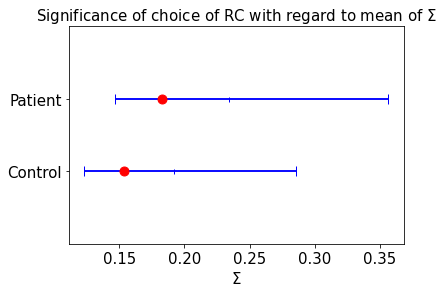

In [20]:
## Reproduce FIGURE 3a)
alpha = 0.95 # alpha percentile
lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))

# Examine the patients group.
rankordered_samples = np.sort(samples_patients)
rankordered_samples = rankordered_samples[lower_limit:upper_limit]
xerr = rankordered_samples[[0,-1]]

y = np.ones([2])
fontsize = 15
markersize = 18

fig = plt.figure()
plt.hlines(y, xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), y[0], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
#plt.ylim([0.5, 5.5])
plt.xlabel('$\Sigma$', fontsize=fontsize)

if mean_rc_var_patients > xerr[1] or mean_rc_var_patients < xerr[0]:
    formatstring = '.g'
else:
    formatstring = '.r'
plt.plot(mean_rc_var_patients, y[0], formatstring, markersize=markersize)

# Examine the control group.
rankordered_samples = np.sort(samples_controls)
rankordered_samples = rankordered_samples[lower_limit:upper_limit]
xerr = rankordered_samples[[0,-1]]

y = np.ones([2])*0.5
fontsize = 15
markersize = 18

plt.hlines(y, xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, y, '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), y[0], '|', color='b', markersize=5)
plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylim([0, 1.5])
plt.xlabel('$\Sigma$', fontsize=fontsize)
plt.title('Significance of choice of RC with regard to mean of $\Sigma$', fontsize=fontsize)

if mean_rc_var_controls > xerr[1] or mean_rc_var_controls < xerr[0]:
    formatstring = '.g'
else:
    formatstring = '.r'
plt.plot(mean_rc_var_controls, y[0], formatstring, markersize=markersize)
plt.show()

### Input-output ratio
The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

The input-output ratio of the periphery takes into account all inter-periphery activity (exclusively).


Patient group:
Mean input-to-output ratio of the rich club:
 1.7830855503682195
95% confidence interval (rich club):
 [0.41462162 3.15154948]
Total input to total output ratio between RC and periphery:
 1.5288530243248348
Mean input-to-output ratio of the priphery:
 1.0286308122084848
95% confidence interval (periphery):
 [0.91777056 1.13949106]
Total input to total output ratio of the priphery:
 1.0000000000000004

Control group:
Mean input-to-output ratio of the rich club:
 1.797726927235594
95% confidence interval (rich club):
 [0.48797271 3.10748114]
Total input to total output ratio between RC and periphery:
 1.5709768991890334
Mean input-to-output ratio of the priphery:
 1.0336493963016784
95% confidence interval (periphery):
 [0.91926012 1.14803868]
Total input to total output ratio of the priphery:
 0.9999999999999999


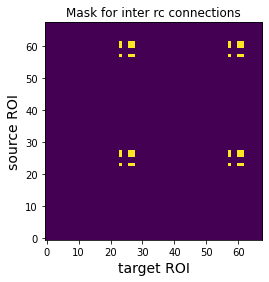

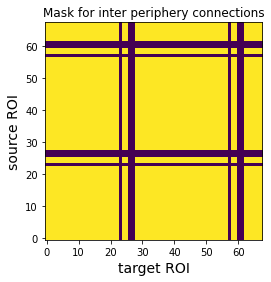

In [21]:
## Calculate the input-to-output ratio of total incoming/outgoing EC.
if input_is_rowsum_flag:
    input_axis = 0
    output_axis = 1
else:
    input_axis = 1
    output_axis = 0

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

## Examine the patients group.
#############################################################################
# Calculate the ratio of incoming/outgoing EC from and to the rich club
#############################################################################
no_rc_connections_C_patients = np.copy(C_patients)
no_rc_connections_C_patients[mask_inter_rc] = 0
if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(no_rc_connections_C_patients,
                                            axis=input_axis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(no_rc_connections_C_patients,
                                             axis=output_axis, keepdims=True))
else:
    roi_input = no_rc_connections_C_patients[:, :].sum(axis=input_axis)
    roi_output = no_rc_connections_C_patients[:, :].sum(axis=output_axis)
    #roi_input = C_mod[:, :, :].sum(axis=1)
    #roi_output = C_mod[:, :, :].sum(axis=2)
io_rc = roi_input[mask_rc] / roi_output[mask_rc]
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:].mean()
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[0]-1, loc=mean_rc_io,
    scale=stt.sem(io_rc)))
print('\nPatient group:')
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))
rc_ratio_of_total_io_patients = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
print('Total input to total output ratio between RC and periphery:\n',
      str(rc_ratio_of_total_io_patients))
# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions
inter_periph_C_patients = np.copy(C_patients)
inter_periph_C_patients[~mask_inter_periph] = 0
if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(inter_periph_C_patients,
                                            axis=input_axis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(inter_periph_C_patients,
                                             axis=output_axis, keepdims=True))
else:
    roi_input = inter_periph_C_patients[:, :].sum(axis=input_axis)
    roi_output = inter_periph_C_patients[:, :].sum(axis=output_axis)
io_periph = (roi_input[~mask_rc] / roi_output[~mask_rc])
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph.mean()
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[0]-1, loc=mean_periph_io,
    scale=stt.sem(io_periph)))
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (periphery):\n', str(conf_int_periph))
periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
                            / roi_output[~mask_rc].sum())
print('Total input to total output ratio of the priphery:\n',
      str(periph_ratio_of_total_io))

## Examine the control group.
#############################################################################
# Calculate the ratio of incoming/outgoing EC from and to the rich club
#############################################################################
no_rc_connections_C_controls = np.copy(C_controls)
no_rc_connections_C_controls[mask_inter_rc] = 0
if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(
        no_rc_connections_C_controls, axis=input_axis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(
        no_rc_connections_C_controls, axis=output_axis, keepdims=True))
else:
    roi_input = no_rc_connections_C_controls[:, :].sum(axis=input_axis)
    roi_output = no_rc_connections_C_controls[:, :].sum(axis=output_axis)
    #roi_input = C_mod[:, :, :].sum(axis=1)
    #roi_output = C_mod[:, :, :].sum(axis=2)
io_rc = roi_input[mask_rc] / roi_output[mask_rc]
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:].mean()
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[0]-1, loc=mean_rc_io,
    scale=stt.sem(io_rc)))
print('\nControl group:')
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))
rc_ratio_of_total_io_controls = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
print('Total input to total output ratio between RC and periphery:\n',
      str(rc_ratio_of_total_io_controls))
# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions
inter_periph_C_controls = np.copy(C_controls)
inter_periph_C_controls[~mask_inter_periph] = 0
if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(inter_periph_C_controls,
                                            axis=input_axis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(inter_periph_C_controls,
                                             axis=output_axis, keepdims=True))
else:
    roi_input = inter_periph_C_controls[:, :].sum(axis=input_axis)
    roi_output = inter_periph_C_controls[:, :].sum(axis=output_axis)
io_periph = (roi_input[~mask_rc] / roi_output[~mask_rc])
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph.mean()
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[0]-1, loc=mean_periph_io,
    scale=stt.sem(io_periph)))
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (periphery):\n', str(conf_int_periph))
periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
                            / roi_output[~mask_rc].sum())
print('Total input to total output ratio of the priphery:\n',
      str(periph_ratio_of_total_io))

#############################################################################
## Examine inter RC input (= output)
#############################################################################
inter_rc_connections_C_patients = np.copy(C_patients)
inter_rc_connections_C_patients[~mask_inter_rc] = 0
inter_rc_connections_C_controls = np.copy(C_controls)
inter_rc_connections_C_controls[~mask_inter_rc] = 0
if io_based_on_nodal_degree_flag:
    inter_rc_input_patients = np.squeeze(np.count_nonzero(
        inter_rc_connections_C_patients, axis=input_axis, keepdims=True))[
        mask_rc].sum()
    inter_rc_output_patients = np.squeeze(np.count_nonzero(
        inter_rc_connections_C_patients, axis=output_axis, keepdims=True))[
        mask_rc].sum()
    inter_rc_input_controls = np.squeeze(np.count_nonzero(
        inter_rc_connections_C_controls, axis=input_axis, keepdims=True))[
        mask_rc].sum()
    inter_rc_output_controls = np.squeeze(np.count_nonzero(
        inter_rc_connections_C_controls, axis=output_axis, keepdims=True))[
        mask_rc].sum()
else:
    inter_rc_input_patients = inter_rc_connections_C_patients.sum(
        axis=input_axis)[mask_rc].sum()
    inter_rc_output_patients = inter_rc_connections_C_patients.sum(
        axis=output_axis)[mask_rc].sum()
    inter_rc_input_controls = inter_rc_connections_C_controls.sum(
        axis=input_axis)[mask_rc].sum()
    inter_rc_output_controls = inter_rc_connections_C_controls.sum(
        axis=output_axis)[mask_rc].sum()

#############################################################################
## Examine output and input from and to the RC  
#############################################################################
if io_based_on_nodal_degree_flag:
    rc_input_patients = np.squeeze(np.count_nonzero(
        no_rc_connections_C_patients, axis=input_axis, keepdims=True))[
        mask_rc].sum()
    rc_output_patients = np.squeeze(np.count_nonzero(
        no_rc_connections_C_patients, axis=output_axis, keepdims=True))[
        mask_rc].sum()
    rc_input_controls = np.squeeze(np.count_nonzero(
        no_rc_connections_C_controls, axis=input_axis, keepdims=True))[
        mask_rc].sum()
    rc_output_controls = np.squeeze(np.count_nonzero(
        no_rc_connections_C_controls, axis=output_axis, keepdims=True))[
        mask_rc].sum()
else:
    rc_input_patients = no_rc_connections_C_patients.sum(
        axis=input_axis)[mask_rc].sum()
    rc_output_patients = no_rc_connections_C_patients.sum(
        axis=output_axis)[mask_rc].sum()
    rc_input_controls = no_rc_connections_C_controls.sum(
        axis=input_axis)[mask_rc].sum()
    rc_output_controls = no_rc_connections_C_controls.sum(
        axis=output_axis)[mask_rc].sum()    

#############################################################################
## Examine inter-periphery input
#############################################################################
if io_based_on_nodal_degree_flag:
    inter_periph_input_patients = np.squeeze(np.count_nonzero(
        inter_periph_C_patients, axis=input_axis, keepdims=True))[
        ~mask_rc].sum()
    inter_periph_output_patients = np.squeeze(np.count_nonzero(
        inter_periph_C_patients, axis=output_axis, keepdims=True))[
        ~mask_rc].sum()
    inter_periph_input_controls = np.squeeze(np.count_nonzero(
        inter_periph_C_controls, axis=input_axis, keepdims=True))[
        ~mask_rc].sum()
    inter_periph_output_controls = np.squeeze(np.count_nonzero(
        inter_periph_C_controls, axis=output_axis, keepdims=True))[
       ~mask_rc].sum()
else:
    inter_periph_input_patients = inter_periph_C_patients.sum(
        axis=input_axis)[~mask_rc].sum()
    inter_periph_output_patients = inter_periph_C_patients.sum(
        axis=output_axis)[~mask_rc].sum()
    inter_periph_input_controls = inter_periph_C_controls.sum(
        axis=input_axis)[~mask_rc].sum()
    inter_periph_output_controls = inter_periph_C_controls.sum(
        axis=output_axis)[~mask_rc].sum()

#############################################################################
## Examine total input
#############################################################################
if io_based_on_nodal_degree_flag:
    total_input_patients = np.count_nonzero(C_patients, axis=input_axis).sum()
    total_output_patients = np.count_nonzero(C_patients, axis=output_axis).sum()
    total_input_controls = np.count_nonzero(C_controls, axis=input_axis).sum()
    total_output_controls = np.count_nonzero(C_controls, axis=output_axis).sum()
else:
    total_input_patients = C_patients[:, :].sum(axis=input_axis).sum()
    total_output_patients = C_patients[:, :].sum(axis=output_axis).sum()
    total_input_controls = C_controls[:, :].sum(axis=input_axis).sum()
    total_output_controls = C_controls[:, :].sum(axis=output_axis).sum()


#############################################################################
## Show masks.
#############################################################################
plt.figure()
plt.imshow(mask_inter_rc, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for inter rc connections', fontsize=12)
plt.show()

plt.figure()
plt.imshow(mask_inter_periph, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for inter periphery connections', fontsize=12)
plt.show()


In [22]:
def analyse_io(mask_rc=mask_rc, mask_inter_rc=mask_inter_rc,
               mask_inter_periph=mask_inter_periph, print_prints=False,
              C_patients=C_patients, C_controls=C_controls):
    """ Analyse the input, the output and the input-to-output ratio for RC,
    feeder and local connections.

    As the input matches the output for all complete graphs/subgraphs, only
    the input is returned in such cases. Otherwise the output and the
    ratio of input devided by output is also returned by this function.   
    """
    ## Calculate the input-to-output ratio of total incoming/outgoing EC.
    if input_is_rowsum_flag:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    ## Examine the patients group.
    # Calculate the ratio of incoming/outgoing EC from and to the rich club
    no_rc_connections_C_patients = np.copy(C_patients)
    no_rc_connections_C_patients[mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(no_rc_connections_C_patients,
                                                axis=input_axis, keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(no_rc_connections_C_patients,
                                                 axis=output_axis, keepdims=True))
    else:
        roi_input = no_rc_connections_C_patients[:, :].sum(axis=input_axis)
        roi_output = no_rc_connections_C_patients[:, :].sum(axis=output_axis)
    io_rc = roi_input[mask_rc] / roi_output[mask_rc]
    # Calculate and print the mean io-ratio and the CI for rich club regions
    mean_rc_io = io_rc[:].mean()
    conf_int_rc = np.array(stt.t.interval(
        0.95, io_rc.shape[0]-1, loc=mean_rc_io,
        scale=stt.sem(io_rc)))
    rc_ratio_of_total_io_patients = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
    if print_prints:
        print('\nPatient group:')
        print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
        print('95% confidence interval (RC):\n', str(conf_int_rc))
        print('Total input to total output ratio between RC and periphery:\n',
              str(rc_ratio_of_total_io_patients))
    # Calculate the ratio of incoming/outgoing EC among peripheral regions
    inter_periph_C_patients = np.copy(C_patients)
    inter_periph_C_patients[~mask_inter_periph] = 0
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(inter_periph_C_patients,
                                                axis=input_axis, keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(inter_periph_C_patients,
                                                 axis=output_axis, keepdims=True))
    else:
        roi_input = inter_periph_C_patients[:, :].sum(axis=input_axis)
        roi_output = inter_periph_C_patients[:, :].sum(axis=output_axis)
    io_periph = (roi_input[~mask_rc] / roi_output[~mask_rc])
    # Calculate and print the mean io-ratio and the CI for peripheral regions
    mean_periph_io = io_periph.mean()
    conf_int_periph = np.array(stt.t.interval(
        0.95, io_periph.shape[0]-1, loc=mean_periph_io,
        scale=stt.sem(io_periph)))
    periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
                            / roi_output[~mask_rc].sum())
    if print_prints:
        print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
        print('95% confidence interval (periphery):\n', str(conf_int_periph))
        print('Total input to total output ratio of the priphery:\n',
              str(periph_ratio_of_total_io))

    ## Examine the control group.
    # Calculate the ratio of incoming/outgoing EC from and to the rich club
    no_rc_connections_C_controls = np.copy(C_controls)
    no_rc_connections_C_controls[mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(
            no_rc_connections_C_controls, axis=input_axis, keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(
            no_rc_connections_C_controls, axis=output_axis, keepdims=True))
    else:
        roi_input = no_rc_connections_C_controls[:, :].sum(axis=input_axis)
        roi_output = no_rc_connections_C_controls[:, :].sum(axis=output_axis)
    io_rc = roi_input[mask_rc] / roi_output[mask_rc]
    # Calculate and print the mean io-ratio and the CI for rich club regions
    mean_rc_io = io_rc[:].mean()
    conf_int_rc = np.array(stt.t.interval(
        0.95, io_rc.shape[0]-1, loc=mean_rc_io,
        scale=stt.sem(io_rc)))
    rc_ratio_of_total_io_controls = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
    if print_prints:
        print('\nControl group:')
        print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
        print('95% confidence interval (RC):\n', str(conf_int_rc))
        print('Total input to total output ratio between RC and periphery:\n',
              str(rc_ratio_of_total_io_controls))
    # Calculate the ratio of incoming/outgoing EC among peripheral regions
    inter_periph_C_controls = np.copy(C_controls)
    inter_periph_C_controls[~mask_inter_periph] = 0
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(inter_periph_C_controls,
                                                axis=input_axis, keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(inter_periph_C_controls,
                                                 axis=output_axis, keepdims=True))
    else:
        roi_input = inter_periph_C_controls[:, :].sum(axis=input_axis)
        roi_output = inter_periph_C_controls[:, :].sum(axis=output_axis)
    io_periph = (roi_input[~mask_rc] / roi_output[~mask_rc])
    # Calculate and print the mean io-ratio and the CI for peripheral regions
    mean_periph_io = io_periph.mean()
    conf_int_periph = np.array(stt.t.interval(
        0.95, io_periph.shape[0]-1, loc=mean_periph_io,
        scale=stt.sem(io_periph)))
    periph_ratio_of_total_io = (roi_input[~mask_rc].sum()
                                / roi_output[~mask_rc].sum())
    if print_prints:
        print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
        print('95% confidence interval (periphery):\n', str(conf_int_periph))
        print('Total input to total output ratio of the priphery:\n',
              str(periph_ratio_of_total_io))

    ## Examine inter RC input (= output)
    inter_rc_connections_C_patients = np.copy(C_patients)
    inter_rc_connections_C_patients[~mask_inter_rc] = 0
    inter_rc_connections_C_controls = np.copy(C_controls)
    inter_rc_connections_C_controls[~mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        inter_rc_input_patients = np.squeeze(np.count_nonzero(
            inter_rc_connections_C_patients, axis=input_axis, keepdims=True))[
            mask_rc].sum()
        inter_rc_output_patients = np.squeeze(np.count_nonzero(
            inter_rc_connections_C_patients, axis=output_axis, keepdims=True))[
            mask_rc].sum()
        inter_rc_input_controls = np.squeeze(np.count_nonzero(
            inter_rc_connections_C_controls, axis=input_axis, keepdims=True))[
            mask_rc].sum()
        inter_rc_output_controls = np.squeeze(np.count_nonzero(
            inter_rc_connections_C_controls, axis=output_axis, keepdims=True))[
            mask_rc].sum()
    else:
        inter_rc_input_patients = inter_rc_connections_C_patients.sum(
            axis=input_axis)[mask_rc].sum()
        inter_rc_output_patients = inter_rc_connections_C_patients.sum(
            axis=output_axis)[mask_rc].sum()
        inter_rc_input_controls = inter_rc_connections_C_controls.sum(
            axis=input_axis)[mask_rc].sum()
        inter_rc_output_controls = inter_rc_connections_C_controls.sum(
            axis=output_axis)[mask_rc].sum()

    ## Examine output and input from and to the RC  
    if io_based_on_nodal_degree_flag:
        rc_input_patients = np.squeeze(np.count_nonzero(
            no_rc_connections_C_patients, axis=input_axis, keepdims=True))[
            mask_rc].sum()
        rc_output_patients = np.squeeze(np.count_nonzero(
            no_rc_connections_C_patients, axis=output_axis, keepdims=True))[
            mask_rc].sum()
        rc_input_controls = np.squeeze(np.count_nonzero(
            no_rc_connections_C_controls, axis=input_axis, keepdims=True))[
            mask_rc].sum()
        rc_output_controls = np.squeeze(np.count_nonzero(
            no_rc_connections_C_controls, axis=output_axis, keepdims=True))[
            mask_rc].sum()
    else:
        rc_input_patients = no_rc_connections_C_patients.sum(
            axis=input_axis)[mask_rc].sum()
        rc_output_patients = no_rc_connections_C_patients.sum(
            axis=output_axis)[mask_rc].sum()
        rc_input_controls = no_rc_connections_C_controls.sum(
            axis=input_axis)[mask_rc].sum()
        rc_output_controls = no_rc_connections_C_controls.sum(
            axis=output_axis)[mask_rc].sum()    

    ## Examine inter-periphery input
    if io_based_on_nodal_degree_flag:
        inter_periph_input_patients = np.squeeze(np.count_nonzero(
            inter_periph_C_patients, axis=input_axis, keepdims=True))[
            ~mask_rc].sum()
        inter_periph_output_patients = np.squeeze(np.count_nonzero(
            inter_periph_C_patients, axis=output_axis, keepdims=True))[
            ~mask_rc].sum()
        inter_periph_input_controls = np.squeeze(np.count_nonzero(
            inter_periph_C_controls, axis=input_axis, keepdims=True))[
            ~mask_rc].sum()
        inter_periph_output_controls = np.squeeze(np.count_nonzero(
            inter_periph_C_controls, axis=output_axis, keepdims=True))[
           ~mask_rc].sum()
    else:
        inter_periph_input_patients = inter_periph_C_patients.sum(
            axis=input_axis)[~mask_rc].sum()
        inter_periph_output_patients = inter_periph_C_patients.sum(
            axis=output_axis)[~mask_rc].sum()
        inter_periph_input_controls = inter_periph_C_controls.sum(
            axis=input_axis)[~mask_rc].sum()
        inter_periph_output_controls = inter_periph_C_controls.sum(
            axis=output_axis)[~mask_rc].sum()

    ## Examine total input
    if io_based_on_nodal_degree_flag:
        total_input_patients = np.count_nonzero(C_patients, axis=input_axis).sum()
        total_output_patients = np.count_nonzero(C_patients, axis=output_axis).sum()
        total_input_controls = np.count_nonzero(C_controls, axis=input_axis).sum()
        total_output_controls = np.count_nonzero(C_controls, axis=output_axis).sum()
    else:
        total_input_patients = C_patients[:, :].sum(axis=input_axis).sum()
        total_output_patients = C_patients[:, :].sum(axis=output_axis).sum()
        total_input_controls = C_controls[:, :].sum(axis=input_axis).sum()
        total_output_controls = C_controls[:, :].sum(axis=output_axis).sum()

    return [inter_periph_input_patients, inter_periph_input_controls,
            inter_rc_input_patients, inter_rc_input_controls,
            total_input_patients, total_input_controls,
            rc_input_patients, rc_input_controls,
            rc_output_patients, rc_output_controls,
            rc_ratio_of_total_io_patients, rc_ratio_of_total_io_controls]

In [23]:
## Implement bootstrapping to verify significance of differences between
# patients and control group
sample_groups_flag = False
sample_groupsize= 'matched' # Options: 'matched', 'all subjects'
if sample_groups_flag:
    from datetime import datetime
    start_time = datetime.now()
    from time import process_time
    start_process_time = process_time()    
    n_samples = 100
    sample_length = np.fmin(n_subjects_patients, n_subjects_controls)
    subj_indexes = np.arange(2*sample_length)
    if sample_groupsize== 'matched':
        all_subjects_timeseries = np.concatenate((
            ts_patients[:sample_length], 
            ts_controls[:sample_length]))
    elif sample_groupsize== 'all subjects':
        all_subjects_timeseries = np.concatenate((
            ts_patients, ts_controls))
    else:
        sample_groupsize= 'matched'
        all_subjects_timeseries = np.concatenate((
            ts_patients[:sample_length], 
            ts_controls[:sample_length]))
        print("Invalidsample_groupsize! The default option 'matched' is applied."
              "Valid options are 'matched' and 'all subjects'")
#    # 45 GB of memory are needed for 10000 samples (1000 seems to work)
#    timeseries_samples = np.zeros([n_samples, sample_length,
#                                   n_rois, n_ts_samples])
    C_samples = np.zeros([n_samples, n_rois, n_rois])
    # Sampling.
    np.random.seed(seed)
    for i_sample in range(n_samples):
        i_index_sample = np.random.choice(subj_indexes, size=sample_length)
#        timeseries_samples[i_sample, :, :, :] = all_subjects_timeseries[
#            i_index_sample]
        timeseries_samples = all_subjects_timeseries[i_index_sample]
#        sample_groups_flag = False

        ## Calculate sample's FC.
        FC = np.ndarray([n_subjects_patients, n_shifts,
                                  n_rois_patients, n_rois_patients])
        for time_shift in time_shifts:
#            FC[:, time_shift, :, :] = calculate_FC_shift(
#                timeseries_samples[i_sample, :, :, :], time_shift)
            FC[:, time_shift, :, :] = calculate_FC_shift(
                timeseries_samples, time_shift)

        # Scale FC so that the max value of every subject's FC is 1.
        FC_scaled = FC/FC[:, _I_NO_TIMESHIFT,:, :].max(
            axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
        # Visualize the effect of the scaling by printing the relevant values.
        #print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

        # Average FC over subjects.
        FC_avg = FC.mean(axis=_SUBJECT_AXIS)
        FC_scaled_avg = FC_scaled.mean(axis=_SUBJECT_AXIS)
        # Scale FC_avg so that the maximal value for each run is 1.
        FC_avg_scaled = FC_avg/FC_avg[
            _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
            np.newaxis, np.newaxis, np.newaxis]

        ## Calculate sample's EC.
        # Run the model optimization.
        # Initialize the source arrays.
        # Jacobian (off-diagonal elements = EC)
        J_mod = np.zeros([n_rois, n_rois])
        # Local variance (input covariance matrix, chosen to be diagonal)
        Sigma_mod = np.zeros([n_rois, n_rois])
        # Model error
        dist_mod = np.zeros([1])
        # Approximation of variance about the fitted data (FC covariance matrices)
        R2_mod = np.zeros([1])
        # Between-region EC matrix
        C_mod = np.zeros([n_rois, n_rois])

        i_tau_opt = 1
        C = np.zeros([n_rois, n_rois], dtype=complex)
        mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().

        if optimize_with_FC_version == 'FC_scaled_avg':
            FC = FC_scaled_avg
        elif optimize_with_FC_version == 'FC_avg_scaled':
            FC = FC_avg_scaled
        elif optimize_with_FC_version == 'FC_avg':
            FC = FC_avg
        else:
            print("!!!WARNING: Invalid Expression for the flag\
            'optimize_with_scaled_FC'!!! Valid terms are\n\
            'FC_scaled_avg', 'FC_avg_scaled', 'FC_avg' (default).")
            FC = FC_avg

        # Run the estimation of model parameters, for all sessions.
        mou_model.fit_LO(FC, i_tau_opt, mask_C=mask_EC, epsilon_C=0.001)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[:, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[:, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_samples[i_sample, :, :] = mou_model.get_C()

        if not(i_sample%(n_samples/1000)):
            print('sample:', i_sample, ';\t model error, R2:',
                  dist_mod, R2_mod)
        #print('sample:', i_sample, ';\t model error, R2:',
        #      dist_mod, R2_mod)
    end_process_time = process_time()
    sampling_process_time = end_process_time - start_process_time
    end_time = datetime.now()
    sampling_time = end_time - start_time
    C_samples_dict = dict(C_samples = C_samples,
                          sampling_process_time = sampling_process_time,
                          sampling_time = sampling_time, seed = seed,
                          sample_groupsize=sample_groupsize)
    np.save(_RES_DIR + 'C_' + str(n_samples) + '_samples' + '_seed_'
            + str(seed) + '.npy', C_samples_dict)
    print('\nFinished!\n')
    print('The optimization for the', n_samples, 'samples took',
          str(sampling_time / 60), 'minutes.')

In [24]:
def sample_groups(n_samples=1000, sample_groupsize='matched',
                  ts_patients=ts_patients,
                  ts_controls=ts_controls,
                  mask_Sigma=mask_Sigma, mask_C=mask_EC):
    """Sample n_samples the size of the smalles of the two groups (patient and 
    control) from the pool of the members of both groups via bootstrapping.
    
    This function takes the two sets of timeseries for patient and control
    group and first calculates the average FC of each sample. After that the
    EC is calculated and the resulting C matrix is stored in _RES_DIR.
    """
    from datetime import datetime
    start_time = datetime.now()
    from time import process_time
    start_process_time = process_time()    
    n_subjects_patients, n_rois, n_ts_samples = ts_patients.shape
    n_subjects_controls, _, _ = ts_controls.shape
    sample_length = np.fmin(n_subjects_patients, n_subjects_controls)
    all_subjects_timeseries = np.concatenate((
        ts_patients, ts_controls))
    subj_indexes = np.arange(2*sample_length)
    if sample_groupsize== 'matched':
        all_subjects_timeseries = np.concatenate((
            ts_patients[:sample_length], 
            ts_controls[:sample_length]))
    elif sample_groupsize== 'all subjects':
        all_subjects_timeseries = np.concatenate((
            ts_patients, ts_controls))
    else:
        sample_groupsize= 'matched'
        all_subjects_timeseries = np.concatenate((
            ts_patients[:sample_length], 
            ts_controls[:sample_length]))
        print("Invalidsample_groupsize! The default option 'matched' is applied."
              "Valid options are 'matched' and 'all subjects'")
    C_samples = np.zeros([n_samples, n_rois, n_rois])
    tau_x = np.zeros([n_samples])
    # Sampling.
    np.random.seed(seed)
    for i_sample in range(n_samples):
        i_index_sample = np.random.choice(subj_indexes, size=sample_length)
        timeseries_samples = all_subjects_timeseries[i_index_sample]
        
        ## Calculate sample's FC.
        if FC_max_shift_length_flag:
            max_shift = 1
            _, FC = \
            calculate_FC_same_timeseries_length(timeseries_samples, max_shift)
        else:
            FC = np.ndarray([n_subjects_patients, n_shifts, 
                                      n_rois_patients, n_rois_patients])
            for time_shift in time_shifts:
                FC[:, time_shift, :, :] = calculate_FC_shift(
                    timeseries_samples, time_shift)

        # Scale FC so that the max value of every subject's FC is 1.
        FC_scaled = FC/FC[:, _I_NO_TIMESHIFT,:, :].max(
            axis=1).max(axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
        # Visualize the effect of the scaling by printing the relevant values.
        #print('Maxima of FC_scaled:\n\n', FC_scaled.max(axis=3).max(axis=3))

        # Average FC over subjects.
        FC_avg = FC.mean(axis=_SUBJECT_AXIS)
        FC_scaled_avg = FC_scaled.mean(axis=_SUBJECT_AXIS)
        # Scale FC_avg so that the maximal value for each run is 1.
        FC_avg_scaled = FC_avg/FC_avg[
            _I_NO_TIMESHIFT,:, :].max(axis=0).max(axis=0)[
            np.newaxis, np.newaxis, np.newaxis]
        
        ## Calculate autocovariance.
        ac = FC[:, :, :].diagonal(axis1=1, axis2=2)
        log_ac = np.log(np.maximum(ac[:, :], 1e-10))
        tau_x[i_sample] = 1/(log_ac[_I_NO_TIMESHIFT, :]
                             - log_ac[_I_ONE_TIMESHIFT, :]).mean()

        ## Calculate sample's EC.
        # Run the model optimization.
        # Initialize the source arrays.
        # Jacobian (off-diagonal elements = EC)
        J_mod = np.zeros([n_rois, n_rois])
        # Local variance (input covariance matrix, chosen to be diagonal)
        Sigma_mod = np.zeros([n_rois, n_rois])
        # Model error
        dist_mod = np.zeros([1])
        # Approximation of variance about the fitted data (FC covariance matrices)
        R2_mod = np.zeros([1])
        # Between-region EC matrix
        C_mod = np.zeros([n_rois, n_rois])

        i_tau_opt = 1
        C = np.zeros([n_rois, n_rois], dtype=complex)
        mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().

        if optimize_with_FC_version == 'FC_scaled_avg':
            FC = FC_scaled_avg
        elif optimize_with_FC_version == 'FC_avg_scaled':
            FC = FC_avg_scaled
        elif optimize_with_FC_version == 'FC_avg':
            FC = FC_avg
        else:
            print("!!!WARNING: Invalid Expression for the flag\
            'optimize_with_scaled_FC'!!! Valid terms are\n\
            'FC_scaled_avg', 'FC_avg_scaled', 'FC_avg' (default).")
            FC = FC_avg

        # Run the estimation of model parameters, for all sessions.
        mou_model.fit_LO(FC, i_tau_opt, mask_Sigma=mask_Sigma,
                         mask_C=mask_EC, epsilon_C=0.001)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[:, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[:, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_samples[i_sample, :, :] = mou_model.get_C()

        if not(i_sample%10):
            print('sample:', i_sample, ';\t model error, R2:',
                  dist_mod, R2_mod)
        #print('sample:', i_sample, ';\t model error, R2:',
        #      dist_mod, R2_mod)
    end_process_time = process_time()
    sampling_process_time = end_process_time - start_process_time
    end_time = datetime.now()
    sampling_time = end_time - start_time
    C_samples_dict = dict(C_samples = C_samples,
                          sampling_process_time = sampling_process_time,
                          sampling_time = sampling_time, seed = seed,
                          sample_groupsize = sample_groupsize,
                          optimize_with_FC_version = optimize_with_FC_version)
    np.save(_RES_DIR + 'C_' + str(n_samples) + '_samples' + '_seed_'
            + str(seed) + '_basedOnFC_' + str(optimize_with_FC_version)
            + '.npy', C_samples_dict)
    np.save(_RES_DIR + 'tau_x_' + str(n_samples) + '_samples' + '_seed_'
            + str(seed) + '_basedOnFC_' + str(optimize_with_FC_version)
            + '.npy', tau_x)
    print('\nFinished!\n')
    print('The optimization for the', n_samples, 'samples took',
          str(sampling_time / 60), 'minutes.')

Determine significance of differences in total input between groups:
	Input:


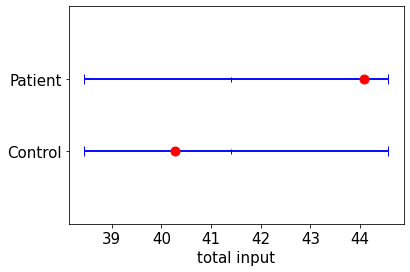

Determine significance of differences in inter-periphery input between groups:
	Input:


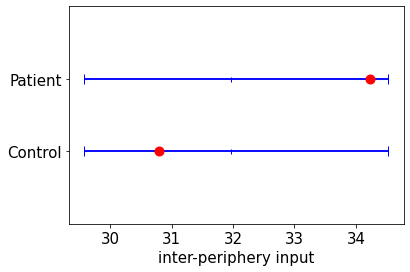

Determine significance of differences in inter-RC input between groups:
	Input:


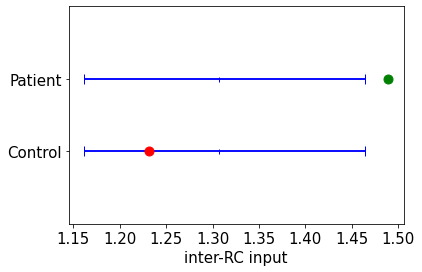

Determine significance of differences in output and input from and to RC between groups:
	Input:


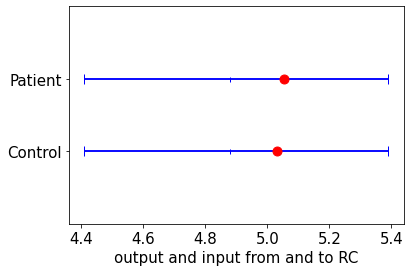

	Output:


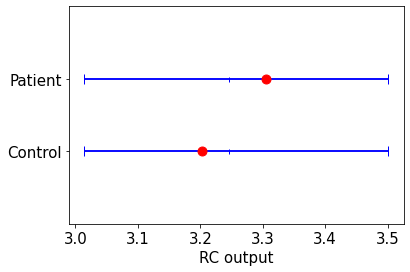

	Input-to-output ratio


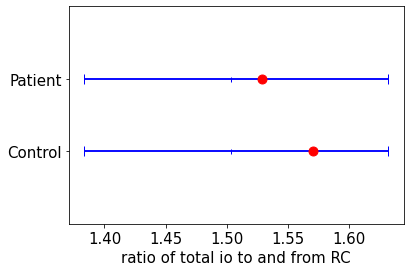

In [25]:
## Analyse sampled mixed groups
#############################################################################
## Analyse EC
#############################################################################
save_analyse_res_flag = True
#sample_groups_flag = True
C_sample_size_options = [100, 1000, 10000]
C_samples_size_option = 2
C_samples_size = C_sample_size_options[C_samples_size_option]
if sample_groups_flag:
    sample_groups(n_samples=C_samples_size)
if C_samples_size_option == 2:
    C_samples = np.load(_RES_DIR + 'C_' + str(C_samples_size) + '_samples'
                        + '_seed_' + str(seed) + '_basedOnFC_'
                        + str(optimize_with_FC_version) + '.npy',
                        allow_pickle=True).tolist()['C_samples']
else:
    C_samples = np.load(_RES_DIR + 'C_' + str(C_samples_size) + '_samples'
                        + '_seed_' + str(seed) + '_basedOnFC_'
                        + str(optimize_with_FC_version) + '.npy')

analyse_in_EC_optioins = ['total input', 'inter-periphery input',
                          'inter-RC input', 'output and input from and to RC']

for analyse_in_EC in analyse_in_EC_optioins:
    if analyse_in_EC == 'inter-periphery input':
        # set 1-D mask
        mask_1D = ~mask_rc
        # set the variable whose significanse is to be analysed
        analyse_for_patients = inter_periph_input_patients
        analyse_for_controls = inter_periph_input_controls
        # alter C according to analysed variable
        altered_C = np.copy(C_samples)
        altered_C[:, ~mask_inter_periph] = 0
    if analyse_in_EC == 'inter-RC input':
        # set 1-D mask
        mask_1D = mask_rc
        # set the variable whose significanse is to be analysed
        analyse_for_patients = inter_rc_input_patients
        analyse_for_controls = inter_rc_input_controls
        # alter C according to analysed variable
        altered_C = np.copy(C_samples)
        altered_C[:, ~mask_inter_rc] = 0
    if analyse_in_EC == 'total input':
        # set 1-D mask
        mask_1D = np.ones(n_rois, dtype=bool)
        # set the variable whose significanse is to be analysed
        analyse_for_patients = total_input_patients
        analyse_for_controls = total_input_controls
        # alter C according to analysed variable
        altered_C = np.copy(C_samples)
    if analyse_in_EC == 'output and input from and to RC':
        # set 1-D mask
        mask_1D = mask_rc
        # set the variable whose significanse is to be analysed
        analyse_for_patients = rc_input_patients
        analyse_for_controls = rc_input_controls
        analyse_out_for_patients = rc_output_patients
        analyse_out_for_controls = rc_output_controls
        analyse_ratio_for_patients = rc_ratio_of_total_io_patients
        analyse_ratio_for_controls = rc_ratio_of_total_io_controls
        # alter C according to analysed variable
        altered_C = np.copy(C_samples)
        altered_C[:, mask_inter_rc] = 0

    print(black(str('Determine significance of differences in ' +
                analyse_in_EC + ' between groups:'), 'bold'))
    if io_based_on_nodal_degree_flag:
        analysed_input = np.squeeze(np.count_nonzero(
            altered_C, axis=input_axis + 1, keepdims=True))
        analysed_output = np.squeeze(np.count_nonzero(
            altered_C, axis=output_axis + 1, keepdims=True))
    else:
        analysed_input = altered_C.sum(axis=input_axis + 1)
        analysed_output = altered_C.sum(axis=output_axis + 1)

    print('\tInput:')
    # Plot CI and mean resulting from bootstrapping.
    alpha = 0.95 # 95 percentile
    lower_limit = int(np.floor(C_samples_size * (1 - alpha) / 2))
    upper_limit = int(np.floor(C_samples_size * (1 + alpha) / 2))
    rankordered_samples = np.sort(analysed_input[:, mask_1D].sum(axis=1))
    rankordered_samples = rankordered_samples[lower_limit:upper_limit]
    xerr = rankordered_samples[[0,-1]]
    fontsize = 15
    fig = plt.figure()
    plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
    # Plot patient and control group data
    # (red for 'not significant', green for 'significant')
    formatstring = '.r'
    if analyse_for_patients > xerr[1] or analyse_for_patients < xerr[0]:
        formatstring = '.g'
    plt.plot(analyse_for_patients, [1], formatstring, markersize=18)

    plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
    formatstring = '.r'
    if analyse_for_controls > xerr[1] or analyse_for_controls < xerr[0]:
        formatstring = '.g'
    plt.plot(analyse_for_controls, [0.5], formatstring, markersize=18)
    plt.xticks(fontsize=fontsize)
    plt.xlabel(analyse_in_EC, fontsize=fontsize)
    plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
    plt.ylim([0, 1.5])
    plt.show()
    # Save figure
    if save_analyse_res_flag:
        if io_based_on_nodal_degree_flag: io_calc_opt = ' nodal degree'
        else: io_calc_opt = ' cont. EC'
        fig.savefig(str('patient_vs_control/' + analyse_in_EC + io_calc_opt
                        + str(C_samples_size) + ' samples and seed '
                        + str(seed) + '.png'), bbox_inches='tight')

    # if the examined graph is not closed, output and input may differ
    if not(np.isclose(analysed_input[:, mask_1D].sum(axis=1),
                      analysed_output[:, mask_1D].sum(axis=1)).all()):
        print('\tOutput:')
        # Plot CI and mean resulting from bootstrapping.
        rankordered_samples = np.sort(analysed_output[:, mask_1D].sum(axis=1))
        rankordered_samples = rankordered_samples[lower_limit:upper_limit]
        xerr = rankordered_samples[[0,-1]]
        fontsize = 15
        fig = plt.figure()
        plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
        plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
        plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
        # Plot patient and control group data
        # (red for 'not significant', green for 'significant')
        formatstring = '.r'
        if (analyse_out_for_patients > xerr[1]
            or analyse_out_for_patients < xerr[0]):
            formatstring = '.g'
        plt.plot(analyse_out_for_patients, [1], formatstring, markersize=18)
        plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
        plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
        plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
        formatstring = '.r'
        if (analyse_out_for_controls > xerr[1]
            or analyse_out_for_controls < xerr[0]):
            formatstring = '.g'
        plt.plot(analyse_out_for_controls, [0.5], formatstring, markersize=18)
        plt.xticks(fontsize=fontsize)
        plt.xlabel("RC output", fontsize=fontsize)
        plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
        plt.ylim([0, 1.5])
        plt.show()
        # Save figure
        if save_analyse_res_flag:
            if io_based_on_nodal_degree_flag: io_calc_opt = ' nodal degree'
            else: io_calc_opt = ' cont. EC'
            fig.savefig(str('patient_vs_control/' + analyse_in_EC + 'output'
                            + io_calc_opt + str(C_samples_size)
                            + ' samples and seed ' + str(seed)
                            + '.png'), bbox_inches='tight')

        print('\tInput-to-output ratio')
        # Plot CI and mean resulting from bootstrapping.
        rankordered_samples = np.sort(
            analysed_input[:, mask_1D].sum(axis=1)
            / analysed_output[:, mask_1D].sum(axis=1))
        rankordered_samples = rankordered_samples[lower_limit:upper_limit]
        xerr = rankordered_samples[[0,-1]]
        fontsize = 15
        fig = plt.figure()
        plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
        plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
        plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
        # Plot patient and control group data
        # (red for 'not significant', green for 'significant')
        formatstring = '.r'
        if (analyse_ratio_for_patients > xerr[1]
            or analyse_ratio_for_patients < xerr[0]):
            formatstring = '.g'
        plt.plot(analyse_ratio_for_patients, [1], formatstring, markersize=18)
        plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
        plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
        plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
        formatstring = '.r'
        if (analyse_ratio_for_controls > xerr[1]
            or analyse_ratio_for_controls < xerr[0]):
            formatstring = '.g'
        plt.plot(analyse_ratio_for_controls, [0.5], formatstring, markersize=18)
        plt.xticks(fontsize=fontsize)
        plt.xlabel("ratio of total io to and from RC", fontsize=fontsize)
        plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
        plt.ylim([0, 1.5])
        plt.show()
        # Save figure
        if save_analyse_res_flag:
            if io_based_on_nodal_degree_flag: io_calc_opt = ' nodal degree'
            else: io_calc_opt = ' cont. EC'
            fig.savefig(str('patient_vs_control/' + analyse_in_EC
                            + ' io ratio' + io_calc_opt + str(C_samples_size)
                            + ' samples and seed ' + str(seed)
                            + '.png'), bbox_inches='tight')

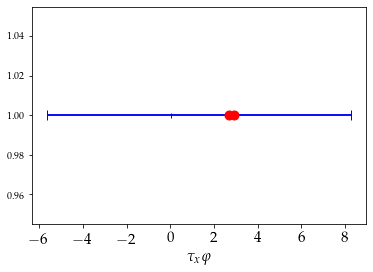

In [44]:
# Examine tau_x.
alpha = 0.95 # alpha percentile
lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
tau_x_samples = np.load(_RES_DIR + 'tau_x_' + str(C_samples_size) + '_samples' + 
                        '_seed_' + str(seed) + '.npy')
rankordered_tau_x = np.sort(tau_x_samples)
rankordered_tau_x = rankordered_tau_x[lower_limit:upper_limit]
xerr = rankordered_tau_x[[0,-1]]

y = np.ones([2])
fontsize = 15
markersize = 18
#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#})

fig = plt.figure()
plt.hlines(y, xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, y, '|', color='b', markersize=10)
plt.plot(rankordered_tau_x.mean(), y[0], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
plt.xlabel('$\\uptau_x$', fontsize=fontsize)

if tau_x_patients > xerr[1] or tau_x_patients < xerr[0]:
    formatstring = '.g'
else:
    formatstring = '.r'
plt.plot(tau_x_patients, y[0], formatstring, markersize=markersize)
if tau_x_controls > xerr[1] or tau_x_controls < xerr[0]:
    formatstring = '.g'
else:
    formatstring = '.r'
plt.plot(tau_x_controls, y[0], formatstring, markersize=markersize)
plt.show()

In [ ]:
def analyse_EC(inter_periph_input_patients=inter_periph_input_patients,
               inter_periph_input_controls=inter_periph_input_controls,
               inter_rc_input_patients=inter_rc_input_patients,
               inter_rc_input_controls=inter_rc_input_controls,
               total_input_patients=total_input_patients,
               total_input_controls=total_input_controls,
               rc_input_patients=rc_input_patients,
               rc_input_controls=rc_input_controls,
               rc_output_patients=rc_output_patients,
               rc_output_controls=rc_output_controls,
               rc_ratio_of_total_io_patients=rc_ratio_of_total_io_patients,
               rc_ratio_of_total_io_controls=rc_ratio_of_total_io_controls,
               mask_rc=mask_rc, mask_inter_periph=mask_inter_periph,):
    """Analyse the EC with respect to the significance of differences between
    groups.
    
    At the moment all of the analyse encapsulated in analyse_in_EC_optioins 
    are included in this function. Of cause it can easily be adapted such that
    a single option the user wants to analyse is passed as a parameter.
    """
    C_sample_size_options = [100, 1000, 10000]
    C_samples_size_option = 2
    C_samples_size = C_sample_size_options[C_samples_size_option]
    # Saved in form of a dictionary
    if C_samples_size_option == 2:
        C_samples = np.load(_RES_DIR + 'C_' + str(C_samples_size) + '_samples'
                            + '_seed_' + str(seed) + '_basedOnFC_'
                            + str(optimize_with_FC_version) + '.npy',
                            allow_pickle=True).tolist()['C_samples']

    # Saved in form of a simple numpy array without additional information
    else:
        C_samples = np.load(_RES_DIR + 'C_' + str(C_samples_size) + '_samples'
                            + '_seed_' + str(seed) + '_basedOnFC_'
                            + str(optimize_with_FC_version) + '.npy')
    analyse_in_EC_optioins = ['total input', 'inter-periphery input',
                              'inter-RC input', 'output and input from and to RC']

    for analyse_in_EC in analyse_in_EC_optioins:
        if analyse_in_EC == 'inter-periphery input':
            # set 1-D mask
            mask_1D = ~mask_rc
            # set the variable whose significanse is to be analysed
            analyse_for_patients = inter_periph_input_patients
            analyse_for_controls = inter_periph_input_controls
            # alter C according to analysed variable
            altered_C = np.copy(C_samples)
            altered_C[:, ~mask_inter_periph] = 0
        if analyse_in_EC == 'inter-RC input':
            # set 1-D mask
            mask_1D = mask_rc
            # set the variable whose significanse is to be analysed
            analyse_for_patients = inter_rc_input_patients
            analyse_for_controls = inter_rc_input_controls
            # alter C according to analysed variable
            altered_C = np.copy(C_samples)
            altered_C[:, ~mask_inter_rc] = 0
        if analyse_in_EC == 'total input':
            # set 1-D mask
            mask_1D = np.ones(n_rois, dtype=bool)
            # set the variable whose significanse is to be analysed
            analyse_for_patients = total_input_patients
            analyse_for_controls = total_input_controls
            # alter C according to analysed variable
            altered_C = np.copy(C_samples)
        if analyse_in_EC == 'output and input from and to RC':
            # set 1-D mask
            mask_1D = mask_rc
            # set the variable whose significanse is to be analysed
            analyse_for_patients = rc_input_patients
            analyse_for_controls = rc_input_controls
            analyse_out_for_patients = rc_output_patients
            analyse_out_for_controls = rc_output_controls
            analyse_ratio_for_patients = rc_ratio_of_total_io_patients
            analyse_ratio_for_controls = rc_ratio_of_total_io_controls
            # alter C according to analysed variable
            altered_C = np.copy(C_samples)
            altered_C[:, mask_inter_rc] = 0

        print(black(str('Determine significance of differences in ' +
                    analyse_in_EC + ' between groups:'), 'bold'))
        if io_based_on_nodal_degree_flag:
            analysed_input = np.squeeze(np.count_nonzero(
                altered_C, axis=input_axis + 1, keepdims=True))
            analysed_output = np.squeeze(np.count_nonzero(
                altered_C, axis=output_axis + 1, keepdims=True))
        else:
            analysed_input = altered_C.sum(axis=input_axis + 1)
            analysed_output = altered_C.sum(axis=output_axis + 1)

        print('\tInput:')
        # Plot CI and mean resulting from bootstrapping.
        alpha = 0.95 # 95 percentile
        lower_limit = int(np.floor(C_samples_size * (1 - alpha) / 2))
        upper_limit = int(np.floor(C_samples_size * (1 + alpha) / 2))
        rankordered_samples = np.sort(analysed_input[:, mask_1D].sum(axis=1))
        rankordered_samples = rankordered_samples[lower_limit:upper_limit]
        xerr = rankordered_samples[[0,-1]]
        fontsize = 15
        fig = plt.figure()
        plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
        plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
        plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
        # Plot patient and control group data
        # (red for 'not significant', green for 'significant')
        formatstring = '.r'
        if analyse_for_patients > xerr[1] or analyse_for_patients < xerr[0]:
            formatstring = '.g'
        plt.plot(analyse_for_patients, [1], formatstring, markersize=18)

        plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
        plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
        plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
        formatstring = '.r'
        if analyse_for_controls > xerr[1] or analyse_for_controls < xerr[0]:
            formatstring = '.g'
        plt.plot(analyse_for_controls, [0.5], formatstring, markersize=18)
        plt.xticks(fontsize=fontsize)
        plt.xlabel(analyse_in_EC, fontsize=fontsize)
        plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
        plt.ylim([0, 1.5])
        plt.show()
        # Save figure
        if save_analyse_res_flag:
            if io_based_on_nodal_degree_flag: io_calc_opt = ' nodal degree'
            else: io_calc_opt = ' cont. EC'
            fig.savefig(str('patient_vs_control/' + analyse_in_EC + io_calc_opt
                            + str(C_samples_size) + ' samples and seed '
                            + str(seed) + '.png'), bbox_inches='tight')

        # if the examined graph is not closed, output and input may differ
        if not(np.isclose(analysed_input[:, mask_1D].sum(axis=1),
                          analysed_output[:, mask_1D].sum(axis=1)).all()):
            print('\tOutput:')
            # Plot CI and mean resulting from bootstrapping.
            rankordered_samples = np.sort(analysed_output[:, mask_1D].sum(axis=1))
            rankordered_samples = rankordered_samples[lower_limit:upper_limit]
            xerr = rankordered_samples[[0,-1]]
            fontsize = 15
            fig = plt.figure()
            plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
            plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
            plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
            # Plot patient and control group data
            # (red for 'not significant', green for 'significant')
            formatstring = '.r'
            if (analyse_out_for_patients > xerr[1]
                or analyse_out_for_patients < xerr[0]):
                formatstring = '.g'
            plt.plot(analyse_out_for_patients, [1], formatstring, markersize=18)
            plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
            plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
            plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
            formatstring = '.r'
            if (analyse_out_for_controls > xerr[1]
                or analyse_out_for_controls < xerr[0]):
                formatstring = '.g'
            plt.plot(analyse_out_for_controls, [0.5], formatstring, markersize=18)
            plt.xticks(fontsize=fontsize)
            plt.xlabel("RC output", fontsize=fontsize)
            plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
            plt.ylim([0, 1.5])
            plt.show()
            # Save figure
            if save_analyse_res_flag:
                if io_based_on_nodal_degree_flag: io_calc_opt = ' nodal degree'
                else: io_calc_opt = ' cont. EC'
                fig.savefig(str('patient_vs_control/' + analyse_in_EC + 'output'
                                + io_calc_opt + str(C_samples_size)
                                + ' samples and seed ' + str(seed)
                                + '.png'), bbox_inches='tight')

            print('\tInput-to-output ratio')
            # Plot CI and mean resulting from bootstrapping.
            rankordered_samples = np.sort(
                analysed_input[:, mask_1D].sum(axis=1)
                / analysed_output[:, mask_1D].sum(axis=1))
            rankordered_samples = rankordered_samples[lower_limit:upper_limit]
            xerr = rankordered_samples[[0,-1]]
            fontsize = 15
            fig = plt.figure()
            plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
            plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
            plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
            # Plot patient and control group data
            # (red for 'not significant', green for 'significant')
            formatstring = '.r'
            if (analyse_ratio_for_patients > xerr[1]
                or analyse_ratio_for_patients < xerr[0]):
                formatstring = '.g'
            plt.plot(analyse_ratio_for_patients, [1], formatstring, markersize=18)
            plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
            plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
            plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
            formatstring = '.r'
            if (analyse_ratio_for_controls > xerr[1]
                or analyse_ratio_for_controls < xerr[0]):
                formatstring = '.g'
            plt.plot(analyse_ratio_for_controls, [0.5], formatstring, markersize=18)
            plt.xticks(fontsize=fontsize)
            plt.xlabel("ratio of total io to and from RC", fontsize=fontsize)
            plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
            plt.ylim([0, 1.5])
            plt.show()
            # Save figure
            if save_analyse_res_flag:
                if io_based_on_nodal_degree_flag: io_calc_opt = ' nodal degree'
                else: io_calc_opt = ' cont. EC'
                fig.savefig(str('patient_vs_control/' + analyse_in_EC
                                + ' io ratio' + io_calc_opt + str(C_samples_size)
                                + ' samples and seed ' + str(seed)
                                + '.png'), bbox_inches='tight')

In [ ]:
## Cluster-based bootstrapping according to section 2.5
## Examine the patients group.
n_samples = 10000
length_of_sample = len(indexes_rich_club)
roi_indexes = np.arange(n_rois)

samples_patients = np.zeros([n_samples])
np.random.seed(seed)
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(
        roi_indexes, size=len(indexes_rich_club))
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True

    mask_inter_sample = np.zeros([n_rois, n_rois], dtype=bool)
    sample_index_combin = np.array(list(
        itertools.product(i_index_sample, repeat=2))).T
    mask_inter_rc[sample_index_combin[0], sample_index_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC from and to the sample
    no_inter_sample_connections_C = np.copy(C_patients[:, :])
    no_inter_sample_connections_C[mask_inter_sample] = 0
    # io ratio represented through nodal degree
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=input_axis,
            keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=output_axis,
            keepdims=True))
    else:
        roi_input = no_inter_sample_connections_C[:, :].sum(
            axis=input_axis)
        roi_output = no_inter_sample_connections_C[:, :].sum(
            axis=output_axis)

    samples_patients[i_sample] = (roi_input[mask_i_sample].sum() /
                                roi_output[mask_i_sample].sum())

## Examine the control group.
samples_controls = np.zeros([n_samples])
np.random.seed(seed)
for i_sample in range(n_samples):
    i_index_sample = np.random.choice(
        roi_indexes, size=len(indexes_rich_club))
    mask_i_sample = np.zeros(n_rois, dtype=bool)
    mask_i_sample[i_index_sample] = True

    mask_inter_sample = np.zeros([n_rois, n_rois], dtype=bool)
    sample_index_combin = np.array(list(
        itertools.product(i_index_sample, repeat=2))).T
    mask_inter_rc[sample_index_combin[0], sample_index_combin[1]] = True
    # Calculate the ratio of incoming/outgoing EC from and to the sample
    no_inter_sample_connections_C = np.copy(C_controls[:, :])
    no_inter_sample_connections_C[mask_inter_sample] = 0
    # io ratio represented through nodal degree
    if io_based_on_nodal_degree_flag:
        roi_input = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=input_axis,
            keepdims=True))
        roi_output = np.squeeze(np.count_nonzero(
            no_inter_sample_connections_C, axis=output_axis,
            keepdims=True))
    else:
        roi_input = no_inter_sample_connections_C[:, :].sum(
            axis=input_axis)
        roi_output = no_inter_sample_connections_C[:, :].sum(
            axis=output_axis)

    samples_controls[i_sample] = (roi_input[mask_i_sample].sum() /
                                roi_output[mask_i_sample].sum())

In [ ]:
## Reproduce FIGURE 3c)
## Examine the patients group.
# Plot CI with marks for the mean and the endpoints
print(black(str('Determine significance of choice of RC regions:'), 'bold'))
alpha = 0.95 # 95 percentile
lower_limit = int(np.floor(C_samples_size * (1 - alpha) / 2))
upper_limit = int(np.floor(C_samples_size * (1 + alpha) / 2))
rankordered_samples = np.sort(samples_patients)
rankordered_samples = rankordered_samples[lower_limit:upper_limit]
xerr = rankordered_samples[[0,-1]]
fontsize = 15
fig = plt.figure()
plt.hlines([1, 1], xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, [1, 1], '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), [1], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
# Plot RC io ratio (red = not significant, green = significant)
io_ratio = rc_ratio_of_total_io_patients
formatstring = '.r'
if io_ratio > xerr[1] or io_ratio < xerr[0]:
    formatstring = '.g'
plt.plot(rc_ratio_of_total_io_patients, [1], formatstring, markersize=18)

## Examine the control group.
# Plot CI with marks for the mean and the endpoints
rankordered_samples = np.sort(samples_controls)
rankordered_samples = rankordered_samples[lower_limit:upper_limit]
xerr = rankordered_samples[[0,-1]]
plt.hlines([0.5, 0.5], xmin=xerr[0], xmax=xerr[1], color='b')
plt.plot(xerr, [0.5, 0.5], '|', color='b', markersize=10)
plt.plot(rankordered_samples.mean(), [0.5], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
plt.ylim([0, 1.5])
# Plot RC io ratio (red = not significant, green = significant)
io_ratio = rc_ratio_of_total_io_controls
formatstring = '.r'
if io_ratio > xerr[1] or io_ratio < xerr[0]:
    formatstring = '.g'
plt.plot(rc_ratio_of_total_io_controls, [0.5], formatstring, markersize=18)
plt.title('rc ratio of total input and output', fontsize=fontsize)
plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
plt.show()
#fig.savefig('rc_significant_choice_nodal_degree_FC_avg.png', bbox_inches='tight')

In [ ]:
## Further investigation of differences between control and patients group
#############################################################################
## Compare total input for all regions
print(black('Compare total input for all regions:', 'bold'))

## Examine the patients group.
print('\tPatients group:')
print('\t\tAs expected, total input and output are the same:',
      total_input_patients == total_output_patients)
print('\t\tTotal input ( == total output) of all regions:', total_input_patients)

## Examine the control group.
print('\tControl group:')
print('\t\tAs expected, total input and output are the same:',
      total_input_controls == total_output_controls)
print('\t\tTotal input ( == total output) of all regions:', total_input_controls)


#############################################################################
## Compare the ratio of incoming/outgoing EC of inter rich club connections
# and inter-RC input
print(black('Compare the ratio of incoming/outgoing EC of inter rich club\
connections and inter-RC input:', 'bold'))
## Examine the patients group.
inter_rc_connections_C = np.copy(C_patients)
inter_rc_connections_C[~mask_inter_rc] = 0
if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(inter_rc_connections_C,
                                            axis=input_axis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(inter_rc_connections_C,
                                             axis=output_axis, keepdims=True))
else:
    roi_input = inter_rc_connections_C[:, :].sum(axis=input_axis)
    roi_output = inter_rc_connections_C[:, :].sum(axis=output_axis)
    #roi_input = C_mod[:, :, :].sum(axis=1)
    #roi_output = C_mod[:, :, :].sum(axis=2)
io_rc = roi_input[mask_rc] / roi_output[mask_rc]
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:].mean()
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[0]-1, loc=mean_rc_io,
    scale=stt.sem(io_rc)))
print('\tPatient group:')
print('\t\tratio of incoming/outgoing EC of inter rich club connections:')
print('\t\tMean input-to-output ratio of the rich club:\n\t\t', str(mean_rc_io))
print('\t\t95% confidence interval (rich club):\n\t\t', str(conf_int_rc))
inter_rc_ratio_of_total_io_patients = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
print('\t\tTotal input to total output ratio of the rich club:\n\t\t',
      str(inter_rc_ratio_of_total_io_patients))
print('\t\tTotal input into the rich club:\n\t\t', roi_input[mask_rc].sum())
print('\t\tRelative input into the rich club:\n\t\t',
      roi_input[mask_rc].sum()/total_input_patients)

## Examine the control group.
inter_rc_connections_C = np.copy(C_controls)
inter_rc_connections_C[~mask_inter_rc] = 0
if io_based_on_nodal_degree_flag:
    roi_input = np.squeeze(np.count_nonzero(inter_rc_connections_C,
                                            axis=input_axis, keepdims=True))
    roi_output = np.squeeze(np.count_nonzero(inter_rc_connections_C,
                                             axis=output_axis, keepdims=True))
else:
    roi_input = inter_rc_connections_C[:, :].sum(axis=input_axis)
    roi_output = inter_rc_connections_C[:, :].sum(axis=output_axis)
    #roi_input = C_mod[:, :, :].sum(axis=1)
    #roi_output = C_mod[:, :, :].sum(axis=2)
io_rc = roi_input[mask_rc] / roi_output[mask_rc]
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:].mean()
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[0]-1, loc=mean_rc_io,
    scale=stt.sem(io_rc)))
print('\tControl group:')
print('\t\tratio of incoming/outgoing EC of inter rich club connections:')
print('\t\tMean input-to-output ratio of the rich club:\n\t\t', str(mean_rc_io))
print('\t\t95% confidence interval (rich club):\n\t\t', str(conf_int_rc))
inter_rc_total_io_controls = (roi_input[mask_rc].sum()
                        / roi_output[mask_rc].sum())
print('\t\tTotal input to total output ratio of the rich club:\n\t\t',
      str(inter_rc_total_io_controls))
print('\t\tTotal input into the rich club:\n\t\t', roi_input[mask_rc].sum())
print('\t\tRelative input into the rich club:\n\t\t',
      roi_input[mask_rc].sum()/total_input_controls)

#############################################################################
## Compare total input (and total output) of FC1
print(black('Compare total input (and total output) of FC1:', 'bold'))
#optimize_with_FC_version = 'FC_avg_scaled'
if optimize_with_FC_version == 'FC_scaled_avg':
    FC_patients = FC_patients_scaled_avg
    FC_controls = FC_controls_scaled_avg
elif optimize_with_FC_version == 'FC_avg_scaled':
    FC_patients = FC_patients_avg_scaled
    FC_controls = FC_controls_avg_scaled
elif optimize_with_FC_version == 'FC_avg':
    FC_patients = FC_patients_avg
    FC_controls = FC_controls_avg
else:
    print("!!!WARNING: Invalid Expression for the flag\
    'optimize_with_scaled_FC'!!! Valid terms are\n\
    'FC_patients_scaled_avg', 'FC_patients_avg_scaled',\
    'FC_patients_avg' (default).")
    FC_patients = FC_patients_avg
    FC_controls = FC_controls_avg
## Examine the patients group.
if io_based_on_nodal_degree_flag:
    total_input = np.count_nonzero(FC_patients[
        _I_ONE_TIMESHIFT,:, :], axis=input_axis).sum()
    total_output = np.count_nonzero(FC_patients[
        _I_ONE_TIMESHIFT,:, :], axis=output_axis).sum()
else:
    total_input = FC_patients[_I_ONE_TIMESHIFT,:, :].sum(
        axis=input_axis).sum()
    total_output = FC_patients[_I_ONE_TIMESHIFT,:, :].sum(
        axis=output_axis).sum()
    print('\tPatients group:')
print('\t\tAs expected, total input and output are the same:',
      total_input == total_output)
print('\t\tTotal input ( == total output) of all regions:', total_input)
## Examine the control group.
if io_based_on_nodal_degree_flag:
    total_input = np.count_nonzero(FC_controls[
        _I_ONE_TIMESHIFT,:, :], axis=input_axis).sum()
    total_output = np.count_nonzero(FC_controls[
        _I_ONE_TIMESHIFT,:, :], axis=output_axis).sum()
else:
    total_input = FC_controls[_I_ONE_TIMESHIFT,:, :].sum(
        axis=input_axis).sum()
    total_output = FC_controls[_I_ONE_TIMESHIFT,:, :].sum(
        axis=output_axis).sum()
    print('\tPatients group:')
print('\t\tAs expected, total input and output are the same:',
      total_input == total_output)
print('\t\tTotal input ( == total output) of all regions:', total_input)

In [ ]:
## Loop through the different definitions of RC
#io_based_on_nodal_degree_flag = True
save_analyse_res_flag = False
show_masks_flag = False
print_prints = False

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True
# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Show masks.
if show_masks_flag:
    plt.figure()
    plt.imshow(mask_inter_rc, origin='lower')
    plt.xlabel('target ROI', fontsize=14)
    plt.ylabel('source ROI', fontsize=14)
    plt.title('Mask for inter rc connections', fontsize=12)
    plt.show()
    plt.figure()
    plt.imshow(mask_inter_periph, origin='lower')
    plt.xlabel('target ROI', fontsize=14)
    plt.ylabel('source ROI', fontsize=14)
    plt.title('Mask for inter periphery connections', fontsize=12)
    plt.show()


# Calculate the mean local variability of the RC.
mean_rc_var_patients, mean_rc_var_controls = analyse_Sigma()

# Calculate the inputs, outputs and input-to-output ratios (total, inter-RC, 
# inter-priphery, between-RC-and-periphery) and extract values relevant for 
# analysis.

[inter_periph_input_patients, inter_periph_input_controls,
 inter_rc_input_patients, inter_rc_input_controls,
 total_input_patients, total_input_controls,
 rc_input_patients, rc_input_controls,
 rc_output_patients, rc_output_controls,
 rc_ratio_of_total_io_patients, rc_ratio_of_total_io_controls] = analyse_io(
    mask_rc=mask_rc, mask_inter_rc=mask_inter_rc,
    mask_inter_periph=mask_inter_periph)
#for i in [inter_periph_input_patients, inter_periph_input_controls,
#          inter_rc_input_patients, inter_rc_input_controls,
#          total_input_patients, total_input_controls,
#          rc_input_patients, rc_input_controls,
#          rc_output_patients, rc_output_controls,
#          rc_ratio_of_total_io_patients, rc_ratio_of_total_io_controls]:
#    print(i)


# Analyse the EC concerning significance differences between the groups.
analyse_EC(inter_periph_input_patients=inter_periph_input_patients,
           inter_periph_input_controls=inter_periph_input_controls,
           inter_rc_input_patients=inter_rc_input_patients,
           inter_rc_input_controls=inter_rc_input_controls,
           total_input_patients=total_input_patients,
           total_input_controls=total_input_controls,
           rc_input_patients=rc_input_patients,
           rc_input_controls=rc_input_controls,
           rc_output_patients=rc_output_patients,
           rc_output_controls=rc_output_controls,
           rc_ratio_of_total_io_patients=rc_ratio_of_total_io_patients,
           rc_ratio_of_total_io_controls=rc_ratio_of_total_io_controls)

save_analyse_res_flag = False

In [ ]:
## Analyze EC-matrixes.
# Compare nonzero EC.
nonzero_C = np.logical_or(C_patients>0, C_controls>0)
masked_C_patients = C_patients[nonzero_C]
masked_C_controls = C_controls[nonzero_C]

# EC Werte der Kontrollgruppe größer Schwellwert und größer bei SZ-Gruppe als entsprechende EC der Kontrollgruppe.  
x = np.linspace(0,C_controls.max(),100)
masks_EC_greater_mean = np.array([masked_C_controls>= i for i in x])
y1 = np.array([(masked_C_patients[mask_EC_greater_mean]>= masked_C_controls[mask_EC_greater_mean]).sum() / mask_EC_greater_mean.sum() for mask_EC_greater_mean in masks_EC_greater_mean])
y2 = np.array([(masked_C_patients[mask_EC_greater_mean]>= masked_C_controls[mask_EC_greater_mean]).sum() for mask_EC_greater_mean in masks_EC_greater_mean])
plt.figure()
plt.plot(x,y1)
# EC Werte der SZ-Gruppe größer Schwellwert und größer bei SZ-Gruppe als entsprechende EC der Kontrollgruppe.  
x = np.linspace(0,C_patients.max(),100)
masks_EC_greater = np.array([masked_C_patients>= i for i in x])
y1 = np.array([(masked_C_patients[mask_EC_greater]>= masked_C_controls[mask_EC_greater]).sum() / mask_EC_greater.sum() for mask_EC_greater in masks_EC_greater])
y2_patients = np.array([(masked_C_patients[mask_EC_greater]>= masked_C_controls[mask_EC_greater]).sum() for mask_EC_greater in masks_EC_greater])
plt.plot(x,y1)
plt.title('connections with higher EC for SZ than for controls')
plt.legend(['biggest control EC connections', 'biggest patient EC connections'])
plt.show()


plt.figure()
# EC Werte der Kontrollgruppe größer Schwelle und größer als die EC gleicher Verbindungen bei der SZ-Gruppe.
plt.plot(x, y2)
# EC Werte der SZ-Gruppe größer Schwelle und größer als die EC gleicher Verbindungen bei der Kontrollgruppe.
plt.plot(x, y2_patients)
# EC Werte größer Schwelle (x-Achse) bei der Kontrollgruppe.
plt.plot(x, [mask_EC_greater_mean.sum() for mask_EC_greater_mean in masks_EC_greater_mean])
# EC Werte größer Schwelle (x-Achse) bei SZ Patienten.
plt.plot(x, [mask_EC_greater.sum() for mask_EC_greater in masks_EC_greater])
plt.show()
print(*["%3.3f" % i for i in x[-20:]])
print(y2[-20:])
print(*["%3.3f" % i for i in y1[-20:]])
print([mask_EC_greater_mean.sum() for mask_EC_greater_mean in masks_EC_greater_mean][-20:])
x[np.where(y1 == max(y1))]
print(max(y1))
np.array([mask_EC_greater_mean.sum() for mask_EC_greater_mean in masks_EC_greater_mean])[np.where(y1 == max(y1))]

In [ ]:
## Examine tendency of big forward-backward difference connections to show 
# bigger difference than the same connections in the other group.

mask_nonzero = np.logical_or(C_patients>0, C_controls>0)
print((mask_EC == mask_EC.T).all())
print((mask_nonzero == mask_nonzero.T).all())
print(mask_nonzero.sum())
mask_nonzero[~(mask_nonzero == mask_nonzero.T)] = True
print((mask_nonzero == mask_nonzero.T).all())

#diff_patients = np.abs(C_patients - C_patients.T)[np.tril(mask_nonzero)]
#diff_controls = np.abs(C_controls - C_controls.T)[np.tril(mask_nonzero)]
#diff_patients = (C_patients - C_patients.T)[np.tril(mask_nonzero)]
#diff_controls = (C_controls - C_controls.T)[np.tril(mask_nonzero)]
diff_patients = (C_patients - C_patients.T)[np.triu(mask_nonzero)]
diff_controls = (C_controls - C_controls.T)[np.triu(mask_nonzero)]
#diff_patients = (C_patients - C_patients.T)[mask_nonzero]
#diff_controls = (C_controls - C_controls.T)[mask_nonzero]
print('Symmetric:', (diff_patients == diff_patients.T).all())
print('Symmetric:', (diff_controls == diff_controls.T).all())
print((diff_patients > diff_controls).sum(), 'of', mask_nonzero.sum())
x = 9/10
mask_patients_greater_mean = diff_patients > (x * diff_patients.mean())
mask_patients_smaller_mean = diff_patients < ((1-x) * diff_patients.mean())
print((diff_patients[mask_patients_greater_mean] > diff_controls[mask_patients_greater_mean]).sum(), 'of', mask_patients_greater_mean.sum())
print((diff_patients[mask_patients_smaller_mean] < diff_controls[mask_patients_smaller_mean]).sum(), 'of', (mask_patients_smaller_mean).sum())


x = np.linspace(diff_patients.min(),diff_patients.max(),100)
masks_patients_greater = [diff_patients >= i for i in x]
masks_patients_smaller = [diff_patients <= i for i in x]
y1 = np.array([(diff_patients[mask_patients_greater]> diff_controls[mask_patients_greater]).sum() / mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])
y2 = np.array([(diff_patients[mask_patients_smaller]< diff_controls[mask_patients_smaller]).sum() / mask_patients_smaller.sum() for mask_patients_smaller in masks_patients_smaller])
plt.plot(x,y1)
plt.plot(x,y2)
minor_locator = AutoMinorLocator(5)
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.grid(which='both')
plt.show()
lim = -30
print(np.array([mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])[lim:])
print(np.array([(diff_patients[mask_patients_greater]> diff_controls[mask_patients_greater]).sum() for mask_patients_greater in masks_patients_greater])[lim:])
print(x[lim:])

x = np.linspace(diff_controls.min(),diff_controls.max(),100)
masks_controls_greater = [diff_controls >= i for i in x]
masks_controls_smaller = [diff_controls <= i for i in x]
y1 = np.array([(diff_patients[mask_controls_greater]> diff_controls[mask_controls_greater]).sum() / mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])
y2 = np.array([(diff_patients[mask_controls_smaller]< diff_controls[mask_controls_smaller]).sum() / mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])
plt.plot(x,y1)
plt.plot(x,y2)
minor_locator = AutoMinorLocator(5)
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.grid(which='both')
plt.show()

print(np.array([mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])[lim:])
print(np.array([(diff_patients[mask_controls_greater]> diff_controls[mask_controls_greater]).sum() for mask_controls_greater in masks_controls_greater])[lim:])
print(x[lim:])

print(np.array([mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])[:25])
print(np.array([(diff_patients[mask_controls_smaller]< diff_controls[mask_controls_smaller]).sum() for mask_controls_smaller in masks_controls_smaller])[:25])
x[:25]



fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax3.spines['top'].set_position(('outward', 35))
ax4 = ax1.twiny()
ax4.spines['top'].set_position(('outward', 70))
ax5 = ax1.twiny()
ax5.spines['top'].set_position(('outward', 105))

x = np.linspace(diff_controls.min(),diff_controls.max(),100)
masks_controls_greater = [diff_controls >= i for i in x]
masks_controls_smaller = [diff_controls <= i for i in x]
y1 = np.array([(diff_controls[mask_controls_greater]> diff_patients[mask_controls_greater]).sum() / mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])
y2 = np.array([(diff_controls[mask_controls_smaller]< diff_patients[mask_controls_smaller]).sum() / mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])
plt.plot(x,y1)
plt.plot(x,y2)


print(np.array([mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])[:50])

x = np.linspace(diff_controls.min(),diff_controls.max(),100)
y1 = np.array([mask_controls_greater.sum()/np.tril(mask_nonzero).sum() for mask_controls_greater in masks_controls_greater])
y2 = np.array([mask_controls_smaller.sum()/np.tril(mask_nonzero).sum() for mask_controls_smaller in masks_controls_smaller])
plt.plot(x,y1)
for xy in zip(x[::10], y1[::10]):
    plt.gca().annotate('(%3.2f)' % xy[0], xy=xy, textcoords='data')
plt.plot(x,y2)
for xy in zip(x[::10], y2[::10]):
    plt.gca().annotate('(%3.2f)' % xy[0], xy=xy, textcoords='data')
xlim = plt.xlim()

minor_locator = AutoMinorLocator(5)
ax1.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.grid(which='both')

ax1.set_xlabel("EC difference")
ax1.set_xlim(xlim)

ax2.set_xlabel("number of greater EC connections (controls)")
ax2.set_xlim(xlim)
ax2.set_xticks(x[::5])
ax2.set_xticklabels(np.array([mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])[::5], fontsize=8)

ax3.set_xlabel("number of lesser EC connections (controls)")
ax3.set_xlim(xlim)
ax3.set_xticks(x[::5])
ax3.set_xticklabels(np.array([mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])[::5], fontsize=8)

x = np.linspace(diff_patients.min(),diff_patients.max(),100)
masks_patients_greater = [diff_patients >= i for i in x]
masks_patients_smaller = [diff_patients <= i for i in x]
y1 = np.array([(diff_patients[mask_patients_greater]> diff_controls[mask_patients_greater]).sum() / mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])
y2 = np.array([(diff_patients[mask_patients_smaller]< diff_controls[mask_patients_smaller]).sum() / mask_patients_smaller.sum() for mask_patients_smaller in masks_patients_smaller])
plt.plot(x,y1)
plt.plot(x,y2)
xlim = plt.xlim()

ax4.set_xlabel("patients greater")
ax4.set_xlim(xlim)
ax4.set_xticks(x[::5])
ax4.set_xticklabels(np.array([mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])[::5], fontsize=8)

ax5.set_xlabel("patients lesser")
ax5.set_xlim(xlim)
ax5.set_xticks(x[::5])
ax5.set_xticklabels(np.array([mask_patients_smaller.sum() for mask_patients_smaller in masks_patients_smaller])[::5], fontsize=8)

x = np.linspace(diff_patients.min(),diff_patients.max(),100)
y1 = np.array([mask_patients_greater.sum()/np.tril(mask_nonzero).sum() for mask_patients_greater in masks_patients_greater])
y2 = np.array([mask_patients_smaller.sum()/np.tril(mask_nonzero).sum() for mask_patients_smaller in masks_patients_smaller])
plt.plot(x,y1)
plt.plot(x,y2)

#fig.tight_layout()
plt.legend(['cg','cl','gc','lc','pg','pl'])
plt.draw()
plt.show()

In [ ]:
## Zur groben Untersuchung, ob controls und patients bei den meisten 
# Differenzen das gleiche Vorzeichen haben.
print('Anteil der Verbindungen mit gleichem Vorzeichen bei SZ- und Kontrollgruppe:', ((diff_patients>=0) == (diff_controls>=0)).sum()/len(diff_patients))
sum_diff = diff_patients + diff_controls
x = np.linspace(sum_diff.min(),sum_diff.max(),100)
masks_sum_greater = [sum_diff >= i for i in x]
masks_sum_smaller = [sum_diff <= i for i in x]
y1 = np.array([(sum_diff[mask_sum_greater]> diff_patients[mask_sum_greater]).sum() / mask_sum_greater.sum() for mask_sum_greater in masks_sum_greater])
y2 = np.array([(sum_diff[mask_sum_smaller]< diff_patients[mask_sum_smaller]).sum() / mask_sum_smaller.sum() for mask_sum_smaller in masks_sum_smaller])
plt.plot(x,y1)
plt.plot(x,y2)

sum_diff = diff_patients + diff_controls
x = np.linspace(sum_diff.min(),sum_diff.max(),100)
masks_sum_greater = [sum_diff >= i for i in x]
masks_sum_smaller = [sum_diff <= i for i in x]
y1 = np.array([(sum_diff[mask_sum_greater]> diff_controls[mask_sum_greater]).sum() / mask_sum_greater.sum() for mask_sum_greater in masks_sum_greater])
y2 = np.array([(sum_diff[mask_sum_smaller]< diff_controls[mask_sum_smaller]).sum() / mask_sum_smaller.sum() for mask_sum_smaller in masks_sum_smaller])
plt.plot(x,y1)
plt.plot(x,y2)

In [ ]:
## Verteilung der Differenzwerte bei controls und patients
print('Anteil (an den ungleich-Null Differenzen) der Verbindungen mit'
      ' forward-backward Differenzen unter- bzw. oberhalb einer Schwelle')
x = np.linspace(diff_patients.min(),diff_patients.max(),100)
masks_sum_greater = [diff_patients > i for i in x]
masks_sum_smaller = [diff_patients < i for i in x]
y1 = np.array([mask_sum_greater.sum()/np.tril(mask_nonzero).sum() for mask_sum_greater in masks_sum_greater])
y2 = np.array([mask_sum_smaller.sum()/np.tril(mask_nonzero).sum() for mask_sum_smaller in masks_sum_smaller])
plt.subplots(figsize=(15,8))
plt.plot(x,y1)
plt.plot(x,y2)

x = np.linspace(diff_controls.min(),diff_controls.max(),100)
masks_sum_greater = [diff_controls > i for i in x]
masks_sum_smaller = [diff_controls < i for i in x]
y1 = np.array([mask_sum_greater.sum()/np.tril(mask_nonzero).sum() for mask_sum_greater in masks_sum_greater])
y2 = np.array([mask_sum_smaller.sum()/np.tril(mask_nonzero).sum() for mask_sum_smaller in masks_sum_smaller])
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()
print(len(diff_patients), np.tril(mask_nonzero).sum())

In [ ]:
# Examine the forwards-backwards manifestation.
threshold_C = max(C_patients.max(), C_controls.max()) * 0.00
C_patients_cut = np.copy(C_patients)
C_controls_cut = np.copy(C_controls)
C_patients_cut[np.logical_or(C_patients<threshold_C, C_controls<threshold_C)] = 0
C_controls_cut[np.logical_or(C_patients<threshold_C, C_controls<threshold_C)] = 0

diff_patients = C_patients_cut - C_patients_cut.T
diff_controls = C_controls_cut - C_controls_cut.T
threshold_diff_patients = 0.00
threshold_diff_controls = 0.00


diff_patients[np.abs(diff_patients)<threshold_diff_patients] = 0.0
diff_controls[np.abs(diff_controls)<threshold_diff_controls] = 0.0

diff_patients_categorized = diff_patients[roi_indexes_categorized, :]
#diff_patients_categorized = np.tril(diff_patients_categorized[:, roi_indexes_categorized])
diff_patients_categorized = diff_patients_categorized[:, roi_indexes_categorized]
diff_controls_categorized = diff_controls[roi_indexes_categorized, :]
#diff_controls_categorized = np.tril(diff_controls_categorized[:, roi_indexes_categorized])
diff_controls_categorized = diff_controls_categorized[:, roi_indexes_categorized]
diff_of_diff = diff_patients_categorized - diff_controls_categorized

# Show for patients.
plt.figure(figsize=(14, 6))
plt.subplot(121)
ax = plt.gca()
im = ax.imshow(diff_patients_categorized, origin='lower', cmap='bwr',
               vmin=-np.abs(diff_patients).max(), vmax=np.abs(diff_patients).max())
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('forwards-backwards patients', fontsize=16)

# Show for controls.
plt.subplot(122)
ax = plt.gca()
im = ax.imshow(diff_controls_categorized, origin='lower', cmap='bwr',
               vmin=-np.abs(diff_patients).max(), vmax=np.abs(diff_patients).max())
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('forwards-backwards controls', fontsize=16)
plt.show()

# Show difference of differencess.
plt.figure(figsize=(14, 14))
plt.grid()
ax = plt.gca()
im = ax.imshow(diff_of_diff,
               origin='lower', cmap='bwr', vmin=-np.abs(diff_of_diff).max(),
               vmax=np.abs(diff_of_diff).max())
#ax.imshow((diff_patients_categorized - diff_controls_categorized)>0,
#          origin='lower', cmap='Greys', alpha=0.2)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_xticks(np.arange(68))
ax.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_yticks(np.arange(68))
ax.set_yticklabels(roi_labels_categorized, fontsize = 10)
ax.set_title('forwards-backwards group difference (patients-controls)', fontsize=16)
ax.set_title('diff_of_diff (patients-controls)', fontsize=16)

sign_of_diff_product = np.sign(diff_patients_categorized.sum(axis=1)*diff_controls_categorized.sum(axis=1))
with np.printoptions(threshold=np.inf):
    print('sign of product of diffs:', sign_of_diff_product)
    print(roi_labels_categorized[sign_of_diff_product<0])
    print('rowsum of diff_patients_categorized:', diff_patients_categorized.sum(axis=1))
    print('rowsum of diff_controls_categorized:', diff_controls_categorized.sum(axis=1))
    print('rowsum of diff_of_diff:', diff_of_diff.sum(axis=1))
# Show for patients.
plt.figure(figsize=(14, 14))
plt.grid()
ax1 = plt.gca()
im = ax1.imshow(diff_patients_categorized, origin='lower', cmap='bwr',
               vmin=-np.abs(diff_patients).max(), vmax=np.abs(diff_patients).max())
devider = make_axes_locatable(ax1)
cax = devider.append_axes('right', size='5%', pad=0.0)
plt.colorbar(im, cax=cax)
ax1.set_xlabel('target ROI', fontsize=14)
ax1.set_xticks(np.arange(68))
ax1.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
ax1.set_ylabel('source ROI', fontsize=14)
ax1.set_yticks(np.arange(68))
ax1.set_yticklabels(roi_labels_categorized, fontsize = 10)
ax1.set_title('forwards-backwards patients', fontsize=16)

threshold_diff_of_diff = np.abs(diff_of_diff).max()*0.66 #*0.52  ca. 5% der Verbindungen#*0.75 nur noch (2) blaue Verbindungen

mask_diff_patients = np.zeros([n_rois, n_rois])
mask_diff_patients[np.abs(diff_of_diff)>threshold_diff_of_diff] = diff_patients_categorized[np.abs(diff_of_diff)>threshold_diff_of_diff]
mask_diff_of_diff = np.zeros([n_rois, n_rois])
mask_diff_of_diff[np.abs(diff_of_diff)>threshold_diff_of_diff] = diff_of_diff[np.abs(diff_of_diff)>threshold_diff_of_diff]
plt.figure(figsize=(14, 14))
plt.grid()
ax2 = plt.gca()
im = ax2.imshow(np.sign(mask_diff_patients*mask_diff_of_diff),
               origin='lower', cmap='bwr',
               vmin=-np.abs(mask_diff_patients*mask_diff_of_diff).max(),
               vmax=np.abs(mask_diff_patients*mask_diff_of_diff).max())
devider = make_axes_locatable(ax2)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax2.set_xlabel('target ROI', fontsize=14)
ax2.set_xticks(np.arange(68))
ax2.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
ax2.set_ylabel('source ROI', fontsize=14)
ax2.set_yticks(np.arange(68))
ax2.set_yticklabels(roi_labels_categorized, fontsize = 10)
ax2.set_title('group difference (patients-controls) * patient´s forwards-backwards difference', fontsize=16)
print('Die Verbindungen mit einer diff_of_diff, die in der oberen Hälfte des',
      ' angenommenen Wertebereichs liegt, stellen einen Anteil an den',
      ' diff_of_diff != 0 Verbindungen von', 
      (mask_diff_patients*mask_diff_of_diff!=0).sum()/(diff_of_diff!=0).sum())

threshold_diff_patients = np.abs(diff_patients_categorized).max()*0.66 #*0.57 ca. 5% der Verbindungen

mask_diff_patients = np.zeros([n_rois, n_rois])
mask_diff_patients[np.abs(diff_patients_categorized)>threshold_diff_patients]= \
diff_patients_categorized[np.abs(diff_patients_categorized)>threshold_diff_patients]
mask_diff_of_diff = np.zeros([n_rois, n_rois])
mask_diff_of_diff[np.abs(diff_patients_categorized)>threshold_diff_patients] = \
diff_of_diff[np.abs(diff_patients_categorized)>threshold_diff_patients]
plt.figure(figsize=(14, 14))
plt.grid()
ax3 = plt.gca()
im = ax3.imshow(np.sign(mask_diff_patients*mask_diff_of_diff),
               origin='lower', cmap='bwr',
               vmin=-np.abs(mask_diff_patients*mask_diff_of_diff).max(),
               vmax=np.abs(mask_diff_patients*mask_diff_of_diff).max())
devider = make_axes_locatable(ax3)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax3.set_xlabel('target ROI', fontsize=14)
ax3.set_xticks(np.arange(68))
ax3.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
ax3.set_ylabel('source ROI', fontsize=14)
ax3.set_yticks(np.arange(68))
ax3.set_yticklabels(roi_labels_categorized, fontsize = 10)
ax3.set_title('group difference (patients-controls) * patient´s forwards-backwards difference', fontsize=16)

# Categorize labels and emphasize rc labels.
frontal_start = 0
frontal_end = len(indexes_frontal) - 1
parietal_start = frontal_end + 1
parietal_end = parietal_start + len(indexes_parietal) - 1
temporal_start = parietal_end + 1
temporal_end = temporal_start + len(indexes_temporal) - 1
occipital_start = temporal_end + 1
occipital_end = occipital_start + len(indexes_occipital) - 1
cingulate_start = occipital_end + 1
cingulate_end = cingulate_start + len(indexes_cingulate) - 1

axis = [ax, ax1, ax2, ax3]
axtypes = ['xaxis', 'yaxis']
rc_indexes = list(list(
    roi_labels_categorized).index(i_label) for i_label in labels_rc)
for ax in axis:
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('top')
    for ax_type in axtypes:
        [label.set_fontsize(fontsize) for label in 
         map(getattr(ax, ax_type).get_majorticklabels().__getitem__, rc_indexes)]

        [label.set_color('green') for label in 
         map(getattr(ax, ax_type).get_majorticklabels().__getitem__,
             np.linspace(frontal_start, frontal_end, len(indexes_frontal), dtype=int))]

        [label.set_color('green') for label in 
         map(getattr(ax, ax_type).get_majorticklabels().__getitem__,
             np.linspace(temporal_start, temporal_end, len(indexes_temporal), dtype=int))]

        [label.set_color('green') for label in 
         map(getattr(ax, ax_type).get_majorticklabels().__getitem__,
             np.linspace(cingulate_start, cingulate_end, len(indexes_cingulate), dtype=int))]
plt.show()
print('Extreme values of diff_of_diff:', diff_of_diff.min(), diff_of_diff.max())
print('Die Verbindungen mit einer diff_patients, die im obereren Drittel des',
      ' angenommenen Wertebereichs liegt, stellen einen Anteil an den',
      ' diff_of_diff != 0 Verbindungen von', 
      (mask_diff_patients*mask_diff_of_diff!=0).sum()/(diff_of_diff!=0).sum())




In [ ]:
print('All rh-rh and all lh-lh couples with the same sign are marked grey.')
#diff_of_diff = diff_patients_categorized - diff_controls_categorized
#diff_of_diff[np.abs(diff_of_diff)<0.01] = 0
threshold = 0.00
thresholded_diff_of_diff = np.zeros([n_rois, n_rois])
thresholded_diff_of_diff[np.abs(diff_of_diff)>threshold] = diff_of_diff[np.abs(diff_of_diff)>threshold]
diff_grater_zero = np.array(np.where((diff_of_diff)>0))
indexes_diff_grater_zero = np.array(np.where((diff_of_diff)>0))
indexes_diff_grater_zero = np.array([i for i in indexes_diff_grater_zero.T if i[0]%2==0])
indexes_right = indexes_diff_grater_zero.T + 1

mask_right = indexes_diff_grater_zero.T + 1 < n_rois
mask_right = np.logical_and(mask_right[0], mask_right[1])
mask_right = np.array([mask_right, mask_right])
indexes_right = indexes_right[mask_right].reshape(2,-1)
indexes_right = indexes_right[:, diff_of_diff[indexes_right[0],indexes_right[1]]>0]    

mask_rh = np.zeros([n_rois, n_rois], dtype='bool')
mask_rh[indexes_right[0], indexes_right[1]] = True
mask_lh = np.zeros([n_rois, n_rois], dtype='bool')
mask_lh[indexes_right[0]-1, indexes_right[1]-1] = True
print(np.logical_or(mask_rh, mask_lh).sum()/(diff_of_diff>0).sum(), '% of the'
      ' positive difference connections follow a lh-rh coupling.')

# Show difference of differencess.
plt.figure(figsize=(14, 14))
plt.grid()
ax = plt.gca()
im = ax.imshow(thresholded_diff_of_diff,
               origin='lower', cmap='bwr', vmin=diff_patients.min(),
               vmax=diff_patients.max())
ax.imshow(np.logical_or(mask_rh, mask_lh), origin='lower', cmap='Greys', alpha=0.3)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_xticks(np.arange(n_rois))
ax.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_yticks(np.arange(n_rois))
ax.set_yticklabels(roi_labels_categorized, fontsize = 10)
ax.set_title('forwards-backwards group difference (patients-controls)', fontsize=16)

diff_lesser_zero = np.array(np.where((diff_of_diff)<0))
indexes_diff_lesser_zero = np.array(np.where((diff_of_diff)<0))
indexes_diff_lesser_zero = np.array([i for i in indexes_diff_lesser_zero.T if i[0]%2==0])
indexes_right = indexes_diff_lesser_zero.T + 1

mask_right = (indexes_right < n_rois)
mask_right = np.array([np.logical_and(mask_right[0],mask_right[1]),np.logical_and(mask_right[0],mask_right[1])])
indexes_right = indexes_right[mask_right].reshape(2,-1)
indexes_right = indexes_right[:, diff_of_diff[indexes_right[0],indexes_right[1]]<0]    

mask_rh = np.zeros([n_rois, n_rois], dtype='bool')
mask_rh[indexes_right[0], indexes_right[1]] = True
mask_lh = np.zeros([n_rois, n_rois], dtype='bool')
mask_lh[indexes_right[0]-1, indexes_right[1]-1] = True
print(np.logical_or(mask_rh, mask_lh).sum()/(diff_of_diff<0).sum(), '% of the'
      ' negative difference connections follow a lh-rh coupling.')
print((diff_of_diff>0).sum()/(diff_of_diff!=0).sum(), 'of the non-zero'
      ' difference connections show a positive difference (patients-controls).')

ax.imshow(np.logical_or(mask_rh, mask_lh), origin='lower', cmap='Greys', alpha=0.2)
#im = ax.imshow(diff_of_diff,
#               origin='lower', cmap='bwr', vmin=diff_patients.min(),
#               vmax=diff_patients.max(), alpha=0.5)
plt.show()

In [ ]:
print('All rh-rh and all lh-lh couples are marked grey irrespective of the sign.')
threshold_C = max(C_patients.max(), C_controls.max()) * 0.1
C_patients_cut = np.copy(C_patients)
C_controls_cut = np.copy(C_controls)
C_patients_cut[np.logical_or(C_patients<threshold_C, C_controls<threshold_C)] = 0
C_controls_cut[np.logical_or(C_patients<threshold_C, C_controls<threshold_C)] = 0

diff_patients = C_patients_cut - C_patients_cut.T
diff_controls = C_controls_cut - C_controls_cut.T
threshold_diff = 0.00


diff_patients[np.logical_or(np.abs(diff_patients)<threshold_diff, np.abs(diff_controls)<threshold_diff)] = 0.0
diff_controls[np.logical_or(np.abs(diff_patients)<threshold_diff, np.abs(diff_controls)<threshold_diff)] = 0.0

diff_patients_categorized = diff_patients[roi_indexes_categorized, :]
#diff_patients_categorized = np.tril(diff_patients_categorized[:, roi_indexes_categorized])
diff_patients_categorized = diff_patients_categorized[:, roi_indexes_categorized]
diff_controls_categorized = diff_controls[roi_indexes_categorized, :]
#diff_controls_categorized = np.tril(diff_controls_categorized[:, roi_indexes_categorized])
diff_controls_categorized = diff_controls_categorized[:, roi_indexes_categorized]

diff_of_diff = diff_patients_categorized - diff_controls_categorized
indexes_diff_grater_zero = np.array(np.where((diff_of_diff)!=0))

# Examine the lh-rh coupling in SC matrix.
#diff_of_diff = mask_EC[roi_indexes_categorized, :]
#diff_of_diff = diff_of_diff[:, roi_indexes_categorized]
#indexes_diff_grater_zero = np.array(np.where((diff_of_diff)!=0))


indexes_diff_grater_zero = np.array([i for i in indexes_diff_grater_zero.T if i[0]%2==0])
indexes_right = indexes_diff_grater_zero.T + 1

mask_right = (indexes_right < n_rois)
mask_right = np.array([np.logical_and(mask_right[0],mask_right[1]),np.logical_and(mask_right[0],mask_right[1])])
indexes_right = indexes_right[mask_right].reshape(2,-1)
indexes_right = indexes_right[:, diff_of_diff[indexes_right[0],indexes_right[1]]!=0]    

mask_rh = np.zeros([n_rois, n_rois], dtype='bool')
mask_rh[indexes_right[0], indexes_right[1]] = True
mask_lh = np.zeros([n_rois, n_rois], dtype='bool')
mask_lh[indexes_right[0]-1, indexes_right[1]-1] = True
print(np.logical_or(mask_rh, mask_lh).sum()/(diff_of_diff!=0).sum(), '% of the'
      ' non-zero dif_of_diff connections follow a lh-rh coupling.')

# Show difference of differencess.
plt.figure(figsize=(14, 14))
plt.grid()
ax = plt.gca()
im = ax.imshow(diff_of_diff,
               origin='lower', cmap='bwr', vmin=diff_patients.min(),
               vmax=diff_patients.max())
ax.imshow(diff_of_diff!=0, origin='lower', cmap='Greens', alpha=0.1)
ax.imshow(np.logical_or(mask_rh, mask_lh), origin='lower', cmap='Greys', alpha=0.3)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_xticks(np.arange(n_rois))
ax.set_xticklabels(roi_labels_categorized, rotation = 90, fontsize = 10)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_yticks(np.arange(n_rois))
ax.set_yticklabels(roi_labels_categorized, fontsize = 10)
ax.set_title('forwards-backwards group difference (patients-controls)', fontsize=16)

plt.show()

In [ ]:
# Examine the forwards-backwards manifestation.
threshold_C = max(C_patients.max(), C_controls.max()) * 0.00
C_patients_cut = np.copy(C_patients)
C_controls_cut = np.copy(C_controls)
C_patients_cut[np.logical_or(C_patients<threshold_C, C_controls<threshold_C)] = 0
C_controls_cut[np.logical_or(C_patients<threshold_C, C_controls<threshold_C)] = 0
diff_patients = C_patients_cut - C_patients_cut.T
diff_controls = C_controls_cut - C_controls_cut.T

threshold_diff_patients = 0.05
threshold_diff_controls = 0.05
diff_patients[np.abs(diff_patients)<threshold_diff_patients] = 0.0
diff_controls[np.abs(diff_controls)<threshold_diff_controls] = 0.0
with np.errstate(divide='ignore', invalid='ignore'):
    patients_ratio = C_patients_cut*C_patients_cut.T
    patients_ratio = diff_patients*diff_controls
    controls_ratio = C_controls_cut*C_controls_cut.T
    #patients_ratio = np.sign(C_patients)*np.sign(C_patients.T)
    #controls_ratio = np.sign(C_controls)*np.sign(C_controls.T)
    #patients_ratio[C_patients.T == 0] = 0
    #patients_ratio[patients_ratio == np.inf] = 0
    #controls_ratio[C_controls.T == 0] = 0
    #controls_ratio[controls_ratio == np.inf] = 0

# Show for patients.
patients_ratio_categorized = patients_ratio[roi_indexes_categorized, :]
#patients_ratio_categorized = np.tril(patients_ratio_categorized[:, roi_indexes_categorized])
patients_ratio_categorized = patients_ratio_categorized[:, roi_indexes_categorized]
plt.figure(figsize=(14, 6))
plt.subplot(121)
ax = plt.gca()
im = ax.imshow(np.sign(patients_ratio_categorized), origin='lower', cmap='bwr')#,
#               vmin=-np.abs(patients_ratio).max(), vmax=np.abs(patients_ratio).max())
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('product of differences', fontsize=16)

# Show for controls.
controls_ratio_categorized = controls_ratio[roi_indexes_categorized, :]
#controls_ratio_categorized = np.tril(controls_ratio_categorized[:, roi_indexes_categorized])
controls_ratio_categorized = controls_ratio_categorized[:, roi_indexes_categorized]
plt.subplot(122)
ax = plt.gca()
im = ax.imshow(np.sign(controls_ratio_categorized), origin='lower', cmap='bwr')#,
#               vmin=-np.abs(patients_ratio).max(), vmax=np.abs(patients_ratio).max())
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('forwards- times backwards-connectivity of controls', fontsize=16)
plt.show()

print('Extreme values of forwards-backwards product-diff_of_diff for patients:', np.nanmin(patients_ratio),
      np.nanmax(patients_ratio[patients_ratio!=np.inf]))

print('Extreme values of forwards-backwards product for controls:', np.nanmin(controls_ratio),
      np.nanmax(controls_ratio[controls_ratio!=np.inf]))

### References
<a id='references'></a>
MOUEC-Estimation notebook by Gilson et al. (2019): Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb

*MOU_Simulation_Estimation* notebook: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson MOU_Simulation_Estimation.ipynb. 2019. https://github.com/mb-BCA/pyMOU/blob/master/examples/MOU_Simulation_Estimation.ipynb

*pyMOU* library: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU 

Senden et al. (2017): M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913